In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/projet-data-RTE/clean-dataset-RTE.csv'

# Import de librairies

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from scipy.stats import chi2_contingency,pearsonr

## charger le dataset

In [5]:
df = pd.read_csv(path, sep=';')

In [6]:
# afficher les 5 premieres lignes
df.head()

,timestamp,consommation_MW,production_MW,Q_total_MVAR,S_total_MVA,cos_phi,frequence_Hz,T1_P_MW,T1_Q_MVAR,T1_I_A,T2_P_MW,T2_Q_MVAR,T2_I_A,etat_reseau,nb_lignes_HT,zone_reseau,jour_type
0,2025-07-22T00:00:00,50000,50334,1529,50023,1.000,49.95,250.68,36.85,605.0,195.14,47.19,645.0,0,4,Nord,ouvrée
1,2025-07-22T00:01:00,50034,50470,1641,50061,0.999,49.98,250.10,63.09,559.3,191.82,45.35,421.4,0,5,Est,ouvrée
2,2025-07-22T00:02:00,50069,50652,2238,50119,0.999,50.04,236.72,47.23,639.6,193.27,37.77,439.6,0,3,Est,ouvrée
3,2025-07-22T00:03:00,50104,50492,1620,50130,0.999,50.03,194.07,43.28,544.3,153.17,23.24,418.6,0,3,Sud,ouvrée
4,2025-07-22T00:04:00,50139,50475,2185,50187,0.999,50.00,189.04,37.46,438.9,182.89,35.07,462.6,0,2,Sud,ouvrée


## quelques infos sur le dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        1440 non-null   object 
 1   consommation_MW  1440 non-null   int64  
 2   production_MW    1440 non-null   int64  
 3   Q_total_MVAR     1440 non-null   int64  
 4   S_total_MVA      1440 non-null   int64  
 5   cos_phi          1440 non-null   float64
 6   frequence_Hz     1440 non-null   float64
 7   T1_P_MW          1440 non-null   float64
 8   T1_Q_MVAR        1440 non-null   float64
 9   T1_I_A           1440 non-null   float64
 10  T2_P_MW          1440 non-null   float64
 11  T2_Q_MVAR        1440 non-null   float64
 12  T2_I_A           1440 non-null   float64
 13  etat_reseau      1440 non-null   int64  
 14  nb_lignes_HT     1440 non-null   int64  
 15  zone_reseau      1440 non-null   object 
 16  jour_type        1440 non-null   object 
dtypes: float64(8),

**On a un dataset de donnees de poste HTA/BT avec 1440 entrées et de 17 colonnes** qui sont:

| Variable              | Signification                                                                 |
| --------------------- | ----------------------------------------------------------------------------- |
| **`timestamp`**       | Date et heure de la mesure (format ISO `YYYY-MM-DDTHH:MM:SS`)                 |
| **`consommation_MW`** | Consommation totale du réseau à cet instant (en mégawatts)                    |
| **`production_MW`**   | Production totale injectée sur le réseau à cet instant (en mégawatts)         |
| **`Q_total_MVAR`**    | Puissance réactive totale sur le réseau (en MVAR : mégavolt-ampères réactifs) |
| **`S_total_MVA`**     | Puissance apparente totale sur le réseau (en MVA : mégavolt-ampères)          |
| **`cos_phi`**         | Facteur de puissance du réseau (`cos(φ)`, compris entre 0 et 1)               |
| **`frequence_Hz`**    | Fréquence instantanée du réseau (en hertz, normalement proche de 50 Hz)       |
| **`T1_P_MW`**         | Puissance active mesurée sur la ligne ou transformateur T1 (en MW)            |
| **`T1_Q_MVAR`**       | Puissance réactive mesurée sur T1 (en MVAR)                                   |
| **`T1_I_A`**          | Courant mesuré sur T1 (en ampères)                                            |
| **`T2_P_MW`**         | Puissance active mesurée sur la ligne ou transformateur T2 (en MW)            |
| **`T2_Q_MVAR`**       | Puissance réactive mesurée sur T2 (en MVAR)                                   |
| **`T2_I_A`**          | Courant mesuré sur T2 (en ampères)                                            |
| **`etat_reseau`**     | Code d’état du réseau (par exemple : 0 = normal, 1 = alerte…)                 |
| **`nb_lignes_HT`**    | Nombre de lignes haute tension actives à cet instant                          |
| **`zone_reseau`**     | Zone géographique du réseau (Nord, Sud, Est…)                                 |
| **`jour_type`**       | Type de jour (ouvré, week-end, jour férié…)                                   |


In [8]:
# chercher la cardinalite de chaque variable
df.nunique()

,0
timestamp,1440
consommation_MW,1413
production_MW,1366
Q_total_MVAR,947
S_total_MVA,1347
cos_phi,5
frequence_Hz,20
T1_P_MW,1339
T1_Q_MVAR,1185
T1_I_A,1174


## separation en variable discretes et continues

Variables continues:
- `timestamp`,`consommation_MW`,`production_MW`,`cos_phi`, `frequence_Hz`, `T1_P_MW`, `T1_Q_MVAR`, `T1_I_A`, `T2_P_MW`,`T2_Q_MVAR`, `T2_I_A`,`Q_total_MVAR`,`S_total_MVA`

Variables discretes:
- `etat_reseau`,`nb_lignes_HT`,`zone_reseau`, `jour_type`


# Analyse univariee

## Analyse variables discrètes

### cos_phi

In [9]:
df['cos_phi'].value_counts(normalize='true')

,proportion
cos_phi,
0.999,0.736806
1.000,0.182639
0.998,0.078472
0.997,0.001389
0.996,0.000694


Text(0.5, 1.0, 'diagramme en barres cos phi')

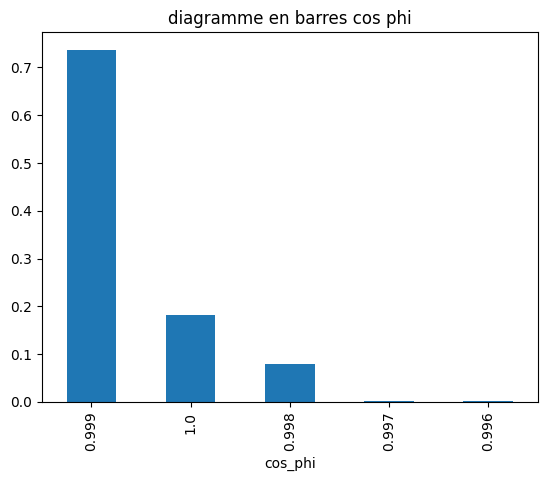

In [10]:
df['cos_phi'].value_counts(normalize='true').plot(kind='bar')
plt.title("diagramme en barres cos phi")

### Analyse:

Le facteur de puissance, ou cos(φ), mesure la proportion d’énergie effectivement utilisée (puissance active) par rapport à l’énergie fournie (apparente). Un facteur de puissance proche de 1 est souhaitable : il signifie que l’énergie délivrée par le réseau est utilisée efficacement.

- Répartition observée :
0.999 représente ~74 % des cas.

1.000 représente ~18 %, ce qui peut être dû à un arrondi ou à des conditions de charge purement résistive (idéal mais rare).

Les autres valeurs (< 0.998) sont ultra-minoritaires (moins de 1 %), ce qui est excellent.

- Lecture du diagramme en barres :
La forte concentration autour de 0.999 témoigne d’un réseau très bien compensé, avec une efficacité énergétique optimale.

L'absence de valeurs basses (< 0.95 ou 0.90) confirme qu’il n’y a pas de surcharge en énergie réactive dans le système, ce qui soulage les transformateurs et lignes haute tension

### etat_reseau

In [11]:
df['etat_reseau'].value_counts(normalize='true')

,proportion
etat_reseau,
0,0.989583
1,0.005556
2,0.004861


Text(0.5, 1.0, 'diagramme en barre etat du reseau')

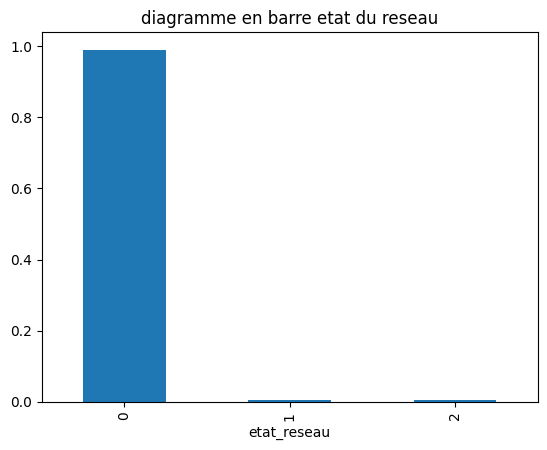

In [12]:
df['etat_reseau'].value_counts(normalize='true').plot(kind='bar')
plt.title("diagramme en barre etat du reseau")

### analyse:

On voit que 98% de l'etat réseau est au statut 0 qui veut dire que le reseau est majoritairement dans un fonctionnement en état optimal

### nb_lignes_HT

In [13]:
df['nb_lignes_HT'].value_counts(normalize='true')

,proportion
nb_lignes_HT,
4,0.315972
3,0.275694
5,0.213889
2,0.194444


Text(0.5, 1.0, 'diagramme en barres nb lignes HT')

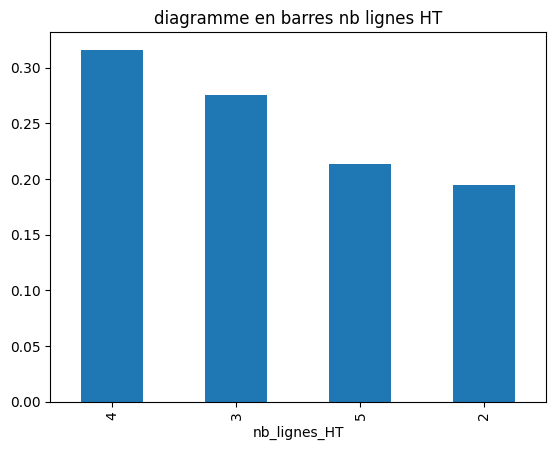

In [14]:
df['nb_lignes_HT'].value_counts(normalize='true').plot(kind='bar')
plt.title("diagramme en barres nb lignes HT")

### Analyse
Durant la journée, seules 4 lignes HT ont été actives/utilsées durant 32% du temps, 3 lignes HT durant 28% du temps, 5 lignes HT durant 21% du temps et 2 lignes durant 19% du temps

### zone_reseau

In [15]:
df['zone_reseau'].value_counts(normalize='true')

,proportion
zone_reseau,
Est,0.212500
Ouest,0.209028
Centre,0.202083
Sud,0.201389
Nord,0.175000


Text(0.5, 1.0, 'diagramme en barres zone reseau')

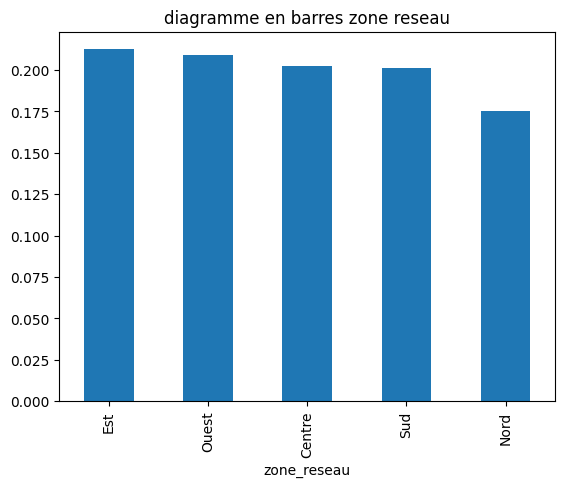

In [16]:
df['zone_reseau'].value_counts(normalize='true').plot(kind='bar')
plt.title("diagramme en barres zone reseau")

### Analyse:

On voit que presques toutes les zones ont sensiblement les mêmes proportion en couverture réseau

### jour_type

In [17]:
df['jour_type'].value_counts(normalize='true')

,proportion
jour_type,
ouvrée,1.0


Text(0.5, 1.0, 'diagramme en barres jour type')

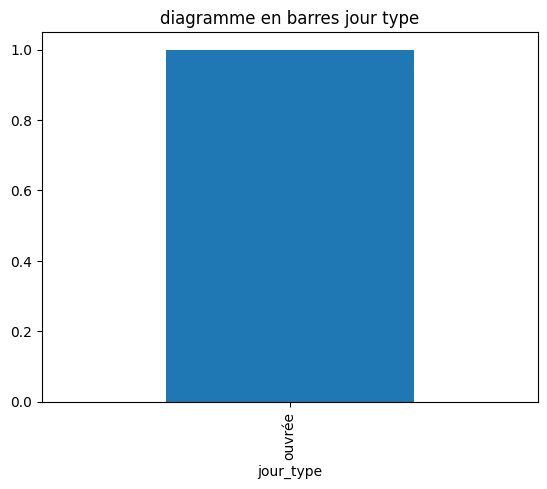

In [18]:
df['jour_type'].value_counts(normalize='true').plot(kind='bar')
plt.title("diagramme en barres jour type")

### Analyse:
Toutes les prises de metriques ont ete realisees en jour ouvrée

## Analyse variables continues

### timestamp

In [19]:
df['timestamp']

,timestamp
0,2025-07-22T00:00:00
1,2025-07-22T00:01:00
2,2025-07-22T00:02:00
3,2025-07-22T00:03:00
4,2025-07-22T00:04:00
...,...
1435,2025-07-22T23:55:00
1436,2025-07-22T23:56:00
1437,2025-07-22T23:57:00
1438,2025-07-22T23:58:00


In [20]:
min_time = df['timestamp'].min()
max_time = df['timestamp'].max()

print(f"debut heure : {min_time}")
print(f"fin heure : {max_time}")

debut heure : 2025-07-22T00:00:00
fin heure : 2025-07-22T23:59:00


### Analyse

`timestamp` est l'horodotage de la prise de metrique et l'heure de date de debut de prise est `2025-07-22T00:00:00` et celle de fin est de `2025-07-22T23:59:00` et la prise se fait par pas de `1 minute`

### consommation_MW

In [21]:
df['consommation_MW'].describe()

,consommation_MW
count,1440.000000
mean,49913.934028
std,5766.486351
min,33322.000000
25%,44202.000000
50%,50000.000000
75%,55650.000000
max,57999.000000


In [22]:


def plot_hist_box(df: DataFrame, col: str):
    """Plot the histogram and boxplot of a variable on the same figure"""

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    sns.histplot(x=df[col], ax=ax[0])
    sns.boxplot(x=df[col], ax=ax[1])

    ax[0].set_title(f"Histogramme et boxplot de '{col}'")

    plt.show()


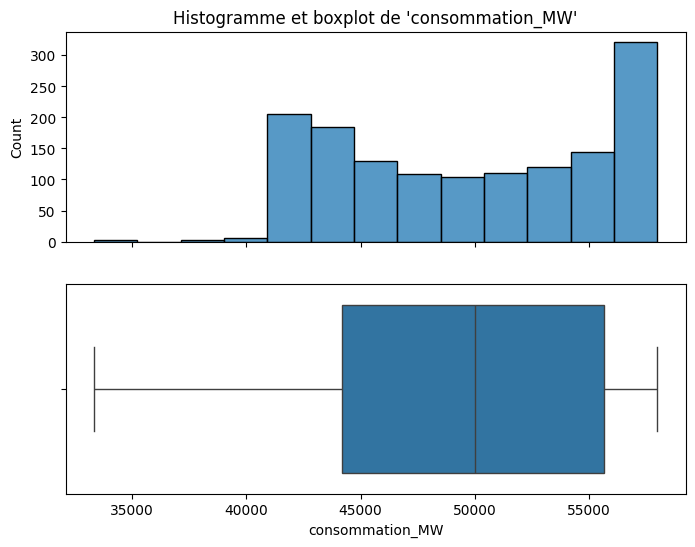

In [23]:
plot_hist_box(df, 'consommation_MW')

### Analyse
L’analyse statistique de la variable `consommation_MW` révèle une consommation moyenne d’environ 49 913 MW, avec une médiane quasi équivalente (50 000 MW), témoignant d’une distribution globalement équilibrée autour de cette valeur centrale. L’écart-type relativement élevé (~5 766 MW) met en évidence une variabilité structurelle importante, liée aux fluctuations naturelles de la demande électrique.

Le boxplot montre une dispersion marquée, sans valeurs aberrantes significatives, ce qui confirme la stabilité du réseau et l’absence d’anomalies majeures sur la période analysée. L’histogramme met en lumière une fréquence accrue des valeurs élevées, notamment autour de 55 000 à 58 000 MW, suggérant des pics de consommation récurrents.

Ces résultats traduisent une consommation fortement influencée par des phénomènes cycliques (heures de la journée, jours de la semaine, saisonnalité) plutôt que par des événements ponctuels. L’ensemble témoigne d’un réseau robuste, répondant à une demande stable mais sujette à des pics prévisibles.



### production_MW

In [24]:
df['production_MW'].describe()

,production_MW
count,1440.000000
mean,50563.127778
std,5649.607665
min,42113.000000
25%,44898.750000
50%,50683.500000
75%,56122.250000
max,58882.000000


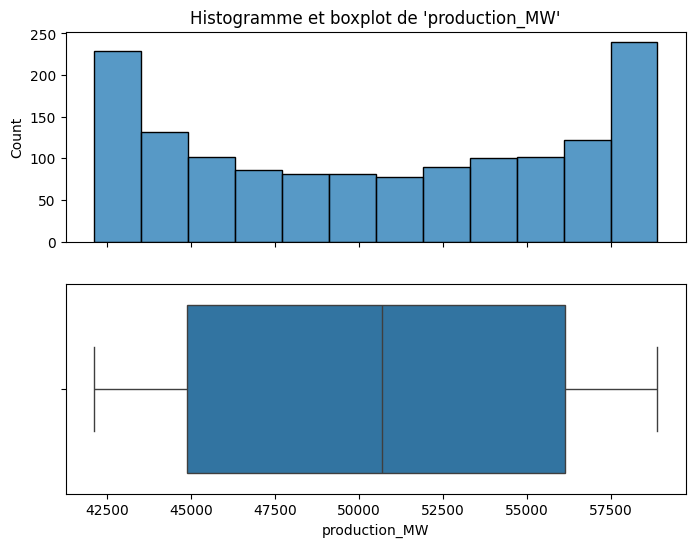

In [25]:
plot_hist_box(df, 'production_MW')

### Analyse:
L’analyse statistique de la production électrique sur la période considérée met en évidence une valeur moyenne de 50 563 MW, très proche de la médiane (50 683 MW). Cette proximité indique un bon équilibre structurel de la production, conforme aux objectifs de régulation en temps réel du réseau.

L’écart-type de 5 650 MW traduit une variabilité maîtrisée, cohérente avec les fluctuations naturelles de la demande et l’ajustement dynamique des moyens de production (notamment pilotables). Le minimum observé de 42 113 MW suggère des phases creuses (probablement nocturnes ou en période de faible demande), tandis que le maximum de 58 882 MW reflète des périodes de forte sollicitation du parc de production.

L’histogramme présente une bimodalité claire, indiquant deux régimes de fonctionnement du système électrique : un régime bas, vraisemblablement lié aux heures creuses, et un régime haut, correspondant aux pointes journalières (matinées ou soirées hivernales typiquement). Ce comportement est classique sur les réseaux fortement corrélés à la consommation résidentielle et aux conditions climatiques.

Le boxplot montre une répartition étendue mais sans outliers apparents, confirmant un pilotage efficace de la production, sans instabilité marquée ni dérive inhabituelle.

### frequence_Hz

In [26]:
df['frequence_Hz'].unique()

array([49.95, 49.98, 50.04, 50.03, 50.  , 50.01, 49.99, 50.05, 49.94,
       49.97, 50.02, 49.92, 50.07, 49.93, 49.91, 50.06, 49.96, 49.9 ,
       50.08, 50.09])

In [27]:
df['frequence_Hz'].describe()

,frequence_Hz
count,1440.000000
mean,49.998646
std,0.029849
min,49.900000
25%,49.980000
50%,50.000000
75%,50.020000
max,50.090000


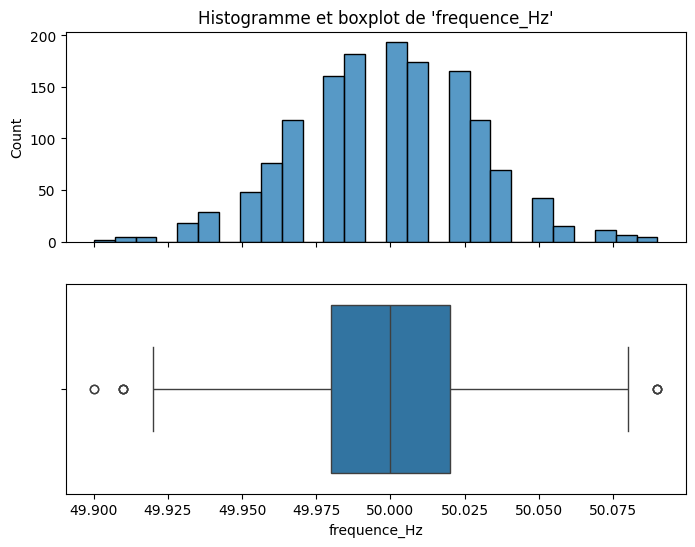

In [28]:
plot_hist_box(df, 'frequence_Hz')

### Analyse:
La fréquence moyenne mesurée est de 49,998 Hz, avec une médiane parfaitement centrée à 50 Hz. L’écart-type extrêmement faible (~0,03 Hz) témoigne d’une très grande stabilité fréquentielle, essentielle pour la sécurité du système électrique.

L’histogramme présente une distribution symétrique en cloche centrée sur 50 Hz, caractéristique d’un réseau bien équilibré. Le boxplot révèle quelques rares écarts, mais tous restent contenus dans les marges de tolérance du réseau interconnecté européen (±1 %), sans signal critique.

#### conclusion:
Le système opéré affiche un excellent pilotage de la fréquence, assurant la stabilité de l’ensemble du réseau malgré les variations naturelles de la consommation et de la production. Ces résultats confirment une exploitation efficace, sans signe de déséquilibre ou de dérive significative.


### T1_P_MW

In [29]:
df['T1_P_MW'].describe()

,T1_P_MW
count,1440.000000
mean,198.819458
std,31.021255
min,113.010000
25%,177.372500
50%,198.545000
75%,220.500000
max,305.870000


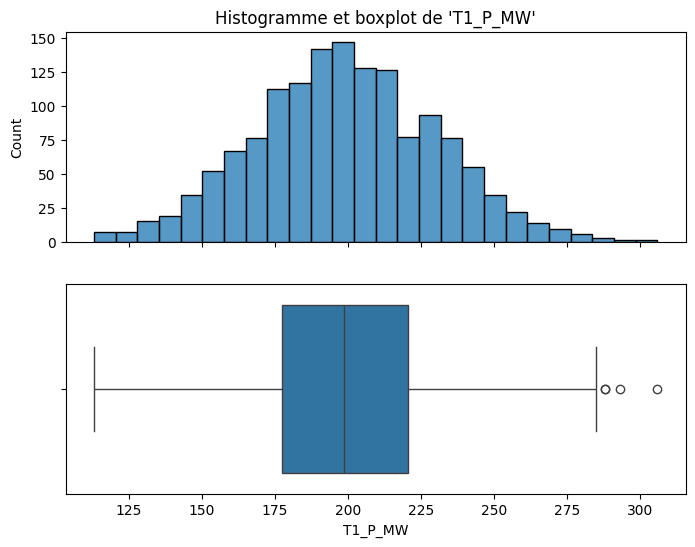

In [30]:
plot_hist_box(df, 'T1_P_MW')

### Analyse
La puissance active T1_P_MW présente une moyenne de 198,8 MW et une médiane de 198,5 MW, ce qui indique une distribution très équilibrée autour de sa valeur centrale. L’écart-type de 31 MW reflète une variabilité modérée, compatible avec un poste ou une ligne soumise à des variations cycliques de charge.

L’histogramme révèle une distribution légèrement asymétrique vers la droite, avec une forte concentration entre 175 MW et 225 MW, typique d’un comportement de charge quotidien régulier. Quelques valeurs hautes (>275 MW) sont identifiées comme outliers, mais elles restent rares.

Le boxplot confirme une bonne stabilité opérationnelle, avec des écarts majoritairement contenus dans l’intervalle interquartile [177,3 – 220,5 MW], ce qui reflète un fonctionnement globalement maîtrisé.

#### conclusion:
T1_P_MW évolue dans une plage stable, avec un profil quasi-normal autour de 200 MW. Les rares dépassements observés au-delà de 275 MW restent ponctuels et ne traduisent pas de déséquilibre structurel. Ce poste ou tronçon semble exploité dans des conditions nominales, sans surcharge persistante ni tension opérationnelle anormale.

### T1_Q_MVAR

In [31]:
df['T1_Q_MVAR'].describe()

,T1_Q_MVAR
count,1440.000000
mean,50.150132
std,10.488622
min,11.630000
25%,43.375000
50%,50.000000
75%,57.305000
max,83.770000


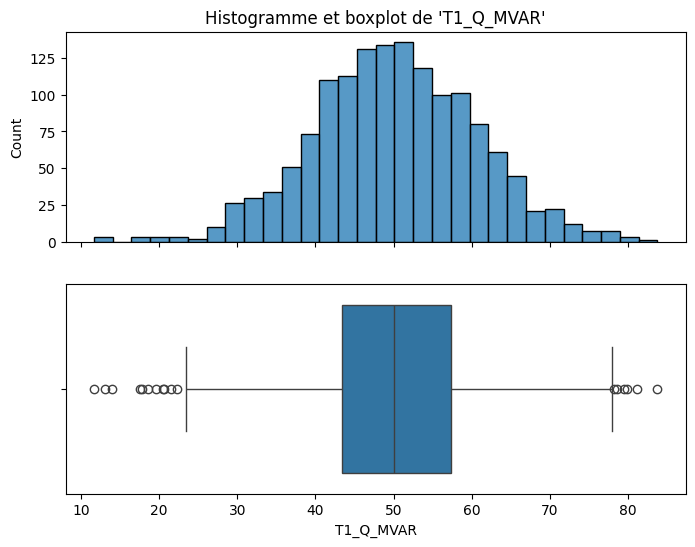

In [32]:
plot_hist_box(df, 'T1_Q_MVAR')

### Analyse:

La variable T1_Q_MVAR affiche une moyenne de 50,15 MVAR et une médiane très proche (50,00 MVAR), ce qui traduit une distribution bien centrée et équilibrée. L’écart-type (~10,5 MVAR) reflète une variabilité maîtrisée, sans instabilité significative.

L’histogramme présente une courbe symétrique en forme de cloche autour de 50 MVAR, typique d’un fonctionnement en régime stable avec une régulation automatique efficace de la compensation réactive (pilotage du cos φ).

Le boxplot révèle quelques valeurs atypiques :

Vers le bas (<30 MVAR), probablement liées à des périodes de faible charge ou à un réglage temporaire de compensation.

Vers le haut (>75 MVAR), pouvant correspondre à des appels réactifs ponctuels ou à des pics de tension nécessitant injection de MVAR.

#### conclusion:

Le comportement de la puissance réactive T1_Q_MVAR est globalement stable et équilibré, avec des pointes modérées. La régulation locale ou distante semble efficace, permettant de maintenir un bon facteur de puissance et une tension réseau stable. Les outliers identifiés restent opérationnellement acceptables, à surveiller seulement si récurrents ou croisés avec un état réseau "tendu".

### T1_I_A

In [33]:
df['T1_I_A'].describe()

,T1_I_A
count,1440.000000
mean,504.424375
std,101.293804
min,236.000000
25%,435.100000
50%,496.600000
75%,564.425000
max,1129.700000


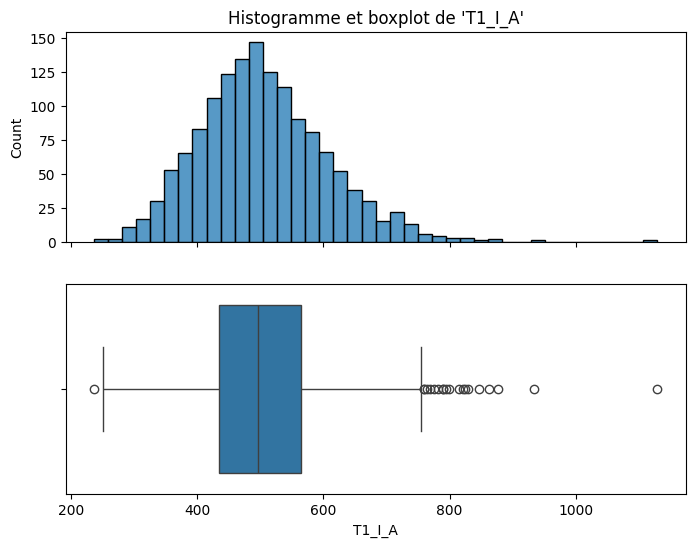

In [34]:
plot_hist_box(df, 'T1_I_A')

### Analyse

La moyenne du courant mesuré est de 504 A, avec une médiane proche (496 A), ce qui indique une distribution centrée. L’écart-type élevé (101 A) reflète une variabilité significative mais attendue dans un contexte de flux énergétique dynamique.

L’histogramme suit une distribution gaussienne légèrement asymétrique, avec un pic autour de 500 A. Cela traduit une activité régulière du poste, probablement liée à un profil de consommation classique (alternance jour/nuit, cycles industriels, etc.).

Le boxplot met en évidence :

Une large concentration entre 435 A (Q1) et 564 A (Q3), zone de fonctionnement nominal.

Des outliers nombreux au-delà de 700 A, jusqu’à un maximum de 1 129 A, qui peuvent signaler :

des pics de charge ponctuels (transferts massifs, démarrages industriels),

ou des phénomènes de transit transitoires, à surveiller si récurrents.

#### Conclusion

Le courant sur le tronçon T1 est globalement stable, centré autour de 500 A. Les valeurs extrêmes restent majoritairement tolérables mais devront être analysées en lien avec la température des câbles, les seuils de déclenchement des protections, ou l’état réseau. Une surveillance ciblée des pointes au-delà de 850 A peut être recommandée.

### T2_P_MW

In [35]:
df['T2_P_MW'].describe()

,T2_P_MW
count,1440.000000
mean,179.449771
std,24.291419
min,95.610000
25%,163.030000
50%,179.175000
75%,196.117500
max,252.850000


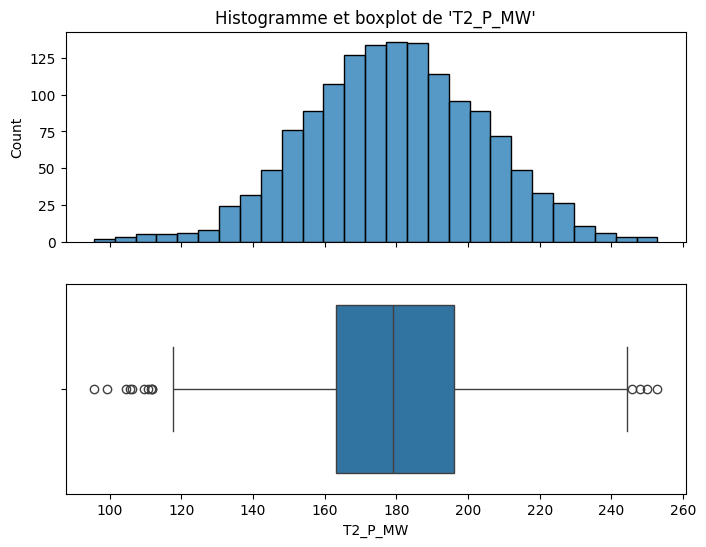

In [36]:
plot_hist_box(df, 'T2_P_MW')

### Analyse
La puissance active mesurée sur le tronçon T2 affiche une moyenne de 179,45 MW et une médiane très proche (179,18 MW), confirmant une distribution parfaitement centrée et un comportement stable du flux énergétique.

L’écart-type modéré (24,29 MW) traduit une variabilité maîtrisée, en cohérence avec les fluctuations normales de charge. La distribution suit une forme quasi-gaussienne, avec une légère asymétrie droite liée à quelques pics rares au-delà de 240 MW.

Le boxplot révèle un fonctionnement concentré entre 163 et 196 MW (zone interquartile), sans signe de surcharge durable. Les valeurs extrêmes restent occasionnelles, sans menace structurelle identifiée.

#### conclusion:
T2_P_MW reflète une exploitation fluide, stable et maîtrisée du tronçon. Le profil observé ne présente ni saturation, ni déséquilibre critique, ce qui confirme un pilotage efficace de la puissance active sur cette portion du réseau

### T2_Q_MVAR

In [37]:
df['T2_Q_MVAR'].describe()

,T2_Q_MVAR
count,1440.000000
mean,45.025049
std,9.885222
min,11.790000
25%,38.587500
50%,44.905000
75%,51.392500
max,78.780000


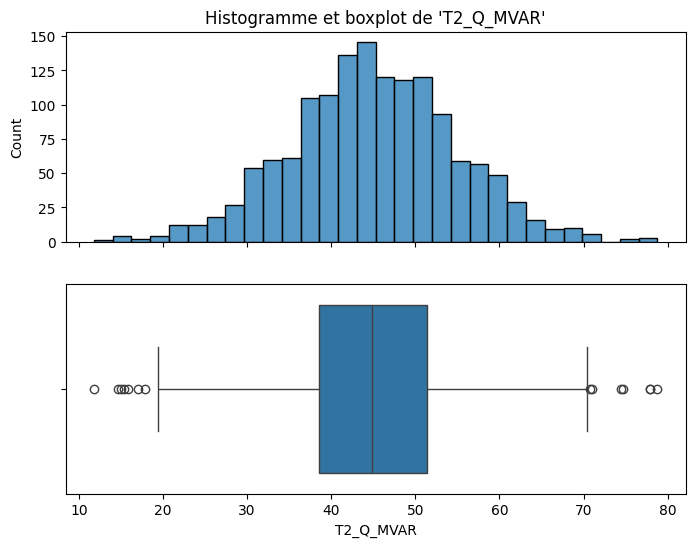

In [38]:
plot_hist_box(df, 'T2_Q_MVAR')


### Analyse
La puissance réactive moyenne mesurée est de 45,03 MVAR, avec une médiane quasi identique (44,91 MVAR), ce qui traduit une distribution très centrée. L’écart-type (~9,88 MVAR) est modéré, indiquant une bonne stabilité du niveau de compensation réactive.

L’histogramme présente une distribution symétrique et resserrée autour de la moyenne, caractéristique d’un comportement stable et bien régulé. Cette forme en cloche est typique d’un pilotage automatisé (par condensateurs, batteries ou régulations locales).

Le boxplot révèle quelques outliers marginaux, à la fois en dessous de 20 MVAR et au-dessus de 70 MVAR. Ces valeurs, bien que rares, peuvent correspondre à des transitoires de compensation ou à des phases de déséquilibre momentané, sans gravité structurelle.

#### conclusion:
T2_Q_MVAR évolue dans une plage très bien maîtrisée, avec une compensation réactive cohérente vis-à-vis des puissances actives observées sur T2. Le profil est celui d’un poste correctement calibré, sans surcharge capacitive ou inductive persistante. Aucun comportement critique n’est identifié.

### T2_I_A

In [39]:
df['T2_I_A'].describe()

,T2_I_A
count,1440.000000
mean,478.947639
std,93.083765
min,220.200000
25%,416.100000
50%,470.700000
75%,533.325000
max,952.300000


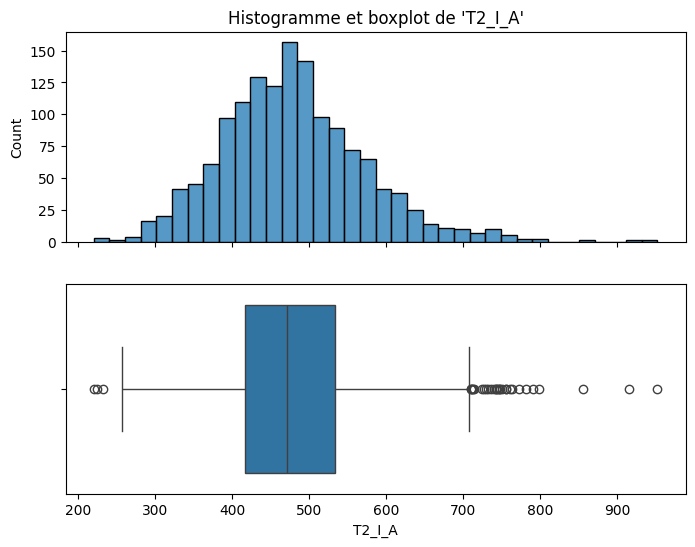

In [40]:
plot_hist_box(df, 'T2_I_A')

### Analyse

La moyenne mesurée est de 504 A, avec une médiane très proche (496 A), traduisant une distribution équilibrée autour de la charge typique du tronçon. L’écart-type (~101 A) est relativement élevé, ce qui reflète une variabilité dynamique attendue, probablement liée aux fluctuations de charge journalières.

L’histogramme présente une distribution symétrique étalée, centrée autour de 500 A, conforme à une exploitation régulière du poste. Le boxplot met en évidence des valeurs extrêmes au-delà de 700 A, jusqu’à un maximum de 929 A, considérées comme pics ponctuels.

Ces outliers sont typiques de transitoires de forte charge (appels de courant, démarrages industriels, pics matin/soir), mais restent relativement rares.

#### conclusion
T2_I_A évolue dans une plage cohérente avec la capacité du tronçon, sans signe de dérive chronique ou de surcharge prolongée. Les excursions au-delà de 850 A méritent un suivi complémentaire, notamment si elles coïncident avec un état réseau tendu. Globalement, le profil courant indique une exploitation maîtrisée et conforme aux seuils opérationnels.

### Q_total_MVAR

In [41]:
df['Q_total_MVAR'].describe()

,Q_total_MVAR
count,1440.000000
mean,1992.113194
std,406.719757
min,803.000000
25%,1712.000000
50%,1987.000000
75%,2253.500000
max,3570.000000


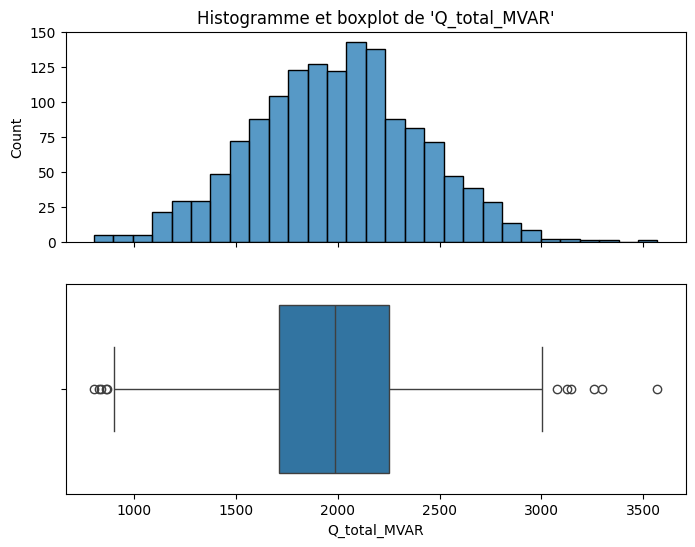

In [42]:
plot_hist_box(df, 'Q_total_MVAR')

### Analyse:
La puissance réactive totale moyenne est de 1 992 MVAR, avec une médiane équivalente (1 987 MVAR), traduisant une distribution symétrique et bien centrée. L’écart-type élevé (~407 MVAR) est justifié par la nature agrégée de la variable : elle reflète l’activité de plusieurs nœuds ou postes simultanément.

L’histogramme présente une distribution équilibrée autour de 2 000 MVAR, avec une forme légèrement aplatie mais régulière. Cela indique un fonctionnement structurel stable, mais avec des charges hétérogènes.

Le boxplot met en évidence :

Des valeurs extrêmes au-delà de 3 000 MVAR, jusqu’à 3 570 MVAR, peu fréquentes mais significatives.

Quelques valeurs faibles (<1 000 MVAR) correspondant probablement à des périodes de faible activité ou de compensation réactive dominante

#### conclusion:
Q_total_MVAR évolue dans une plage cohérente avec un réseau de grande échelle. La régulation de la réactivité est globalement maîtrisée, avec des variations correspondant à l’évolution naturelle de la charge. Les valeurs extrêmes peuvent indiquer :

soit des périodes de forte sollicitation (hiver, pics),

soit des déséquilibres locaux temporairement compensés au niveau global.

À ce stade, aucun comportement critique n’est identifié, mais une surveillance corrélée à l’état réseau ou au cos φ pourrait permettre d’affiner la lecture opérationnelle.

### S_total_MVA

In [43]:
df['S_total_MVA'].describe()

,S_total_MVA
count,1440.000000
mean,49955.902778
std,5761.621281
min,33396.000000
25%,44238.750000
50%,50043.500000
75%,55689.500000
max,58052.000000


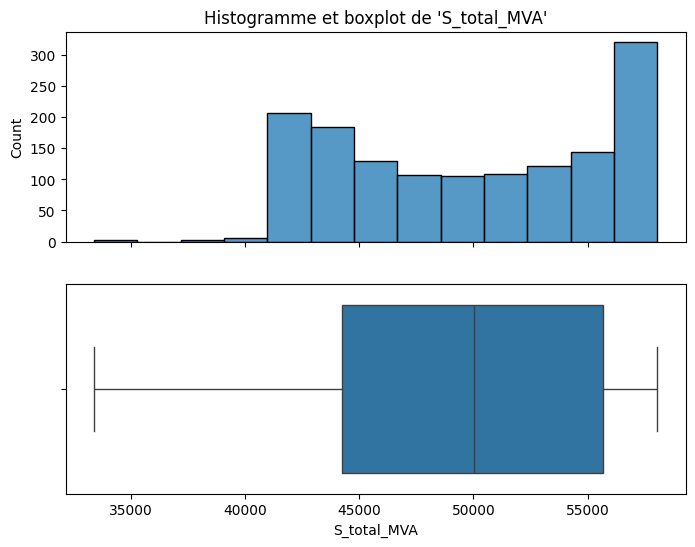

In [44]:
plot_hist_box(df, 'S_total_MVA')

## Analyse multivariee

### Discretes / Discretes

#### cos_phi /etat_reseau

In [45]:
# tableau de contingence
pd.crosstab(df['cos_phi'], df['etat_reseau'])

etat_reseau,0,1,2
cos_phi,,,
0.996,0,1,0
0.997,1,1,0
0.998,109,0,4
0.999,1053,5,3
1.000,262,1,0


<Axes: xlabel='etat_reseau', ylabel='cos_phi'>

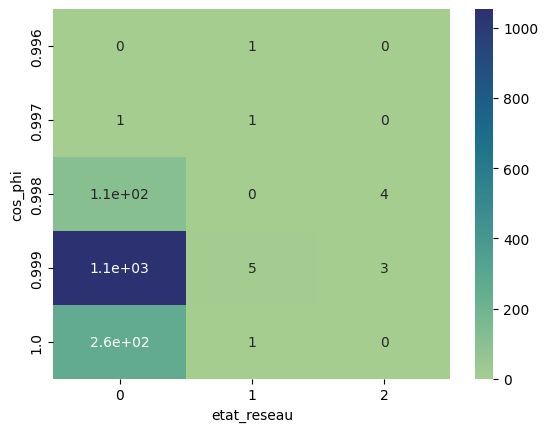

In [46]:
sns.heatmap(pd.crosstab(df['cos_phi'], df['etat_reseau']), annot=True,cmap='crest')

### Analyse:

Majorité des cas (1053/1440) ont un cos_phi = 0.999 et sont associés à un état réseau normal (0)
➤ Facteur de puissance élevé = réseau stable

Les états tendus (1) et très tendus (2) sont très rares, et ne sont jamais liés à un cos φ faible :

Aucun état 2 en dessous de 0.998

Aucun cas tendu en dessous de 0.997

La concentration des valeurs autour de 0.999 et 1.000 confirme une excellente qualité de compensation réactive sur l’ensemble du réseau, même en conditions stressées.

### HYPOTHESE À TESTER:
Pour voir si y a une relation entre le facteur de puissance et l'etat du reseau posons
#### "H0 : \"Il n'y a pas de relation entre le facteur de puissance (cos_phi) et l'état du réseau.\""

In [47]:
# Hypothèse nulle
print("H0 : \"Il n'y a pas de relation entre le facteur de puissance (cos_phi) et l'état du réseau.\"")
print()

# Seuil de signification
alpha = 0.05

# Table de contingence
contingency_table = pd.crosstab(df["cos_phi"], df["etat_reseau"])

# Calcul de la p-value
p_value = chi2_contingency(contingency_table).pvalue

# Décision
if p_value < alpha:
    print("✅ Nous avons suffisamment d'évidences pour rejeter H0.")
    print("➡️ Il existe une relation statistiquement significative entre cos_phi et l'état du réseau.")
else:
    print("❌ Nous n'avons pas suffisamment d'évidences pour rejeter H0.")
    print("➡️ Aucune relation statistiquement significative détectée entre cos_phi et l'état du réseau.")

# Affichage de la p-value
print(f"\n(p-value = {p_value:.5f}, alpha = {alpha})")


H0 : "Il n'y a pas de relation entre le facteur de puissance (cos_phi) et l'état du réseau."

✅ Nous avons suffisamment d'évidences pour rejeter H0.
➡️ Il existe une relation statistiquement significative entre cos_phi et l'état du réseau.

(p-value = 0.00000, alpha = 0.05)


### cos_phi/zone_reseau

In [48]:
table_contingence = pd.crosstab(df['cos_phi'], df['zone_reseau'])
table_contingence

zone_reseau,Centre,Est,Nord,Ouest,Sud
cos_phi,,,,,
0.996,0,0,0,0,1
0.997,0,0,1,0,1
0.998,21,19,17,33,23
0.999,218,227,186,221,209
1.000,52,60,48,47,56


<Axes: xlabel='zone_reseau', ylabel='cos_phi'>

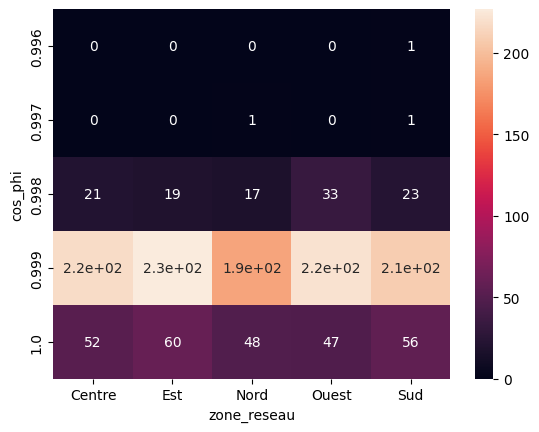

In [49]:
sns.heatmap(table_contingence, annot=True)

### Analyse

Le facteur de puissance cos(φ) = 0.999 domine dans toutes les zones, indiquant une compensation réactive optimale et homogène sur le territoire.

Aucune zone ne présente d’écart significatif ou de concentration anormale dans les faibles cos(φ).

Les valeurs extrêmes (0.996, 0.997) sont rares et dispersées, sans impact régional marqué.

#### conclusion:
Le réseau présente une qualité de compensation réactive stable dans toutes les zones géographiques, sans déséquilibre régional détecté. Le niveau de cos(φ) reste globalement élevé et uniforme, conforme aux standards d’exploitation RTE.

## Continue / Continue

### timestamp / consommation_MW , timestamp/production_MW, timestamp/T1_P_MW, timestamp/T2_P_MW, timestamp/T2_I_A, timestamp/S_total_MVA

Pour faciliter le tracé nous allons convertir le timestamp en intervalle de pas constant (pas 1minute) ainsi nous aurions un intervalle de 0 à 1440minutes  avec 1440 points  donc timestamp devient 'timestamp_minute'

In [50]:
df = df.sort_values('timestamp').reset_index(drop=True)
df['timestamp_minute'] = df.index


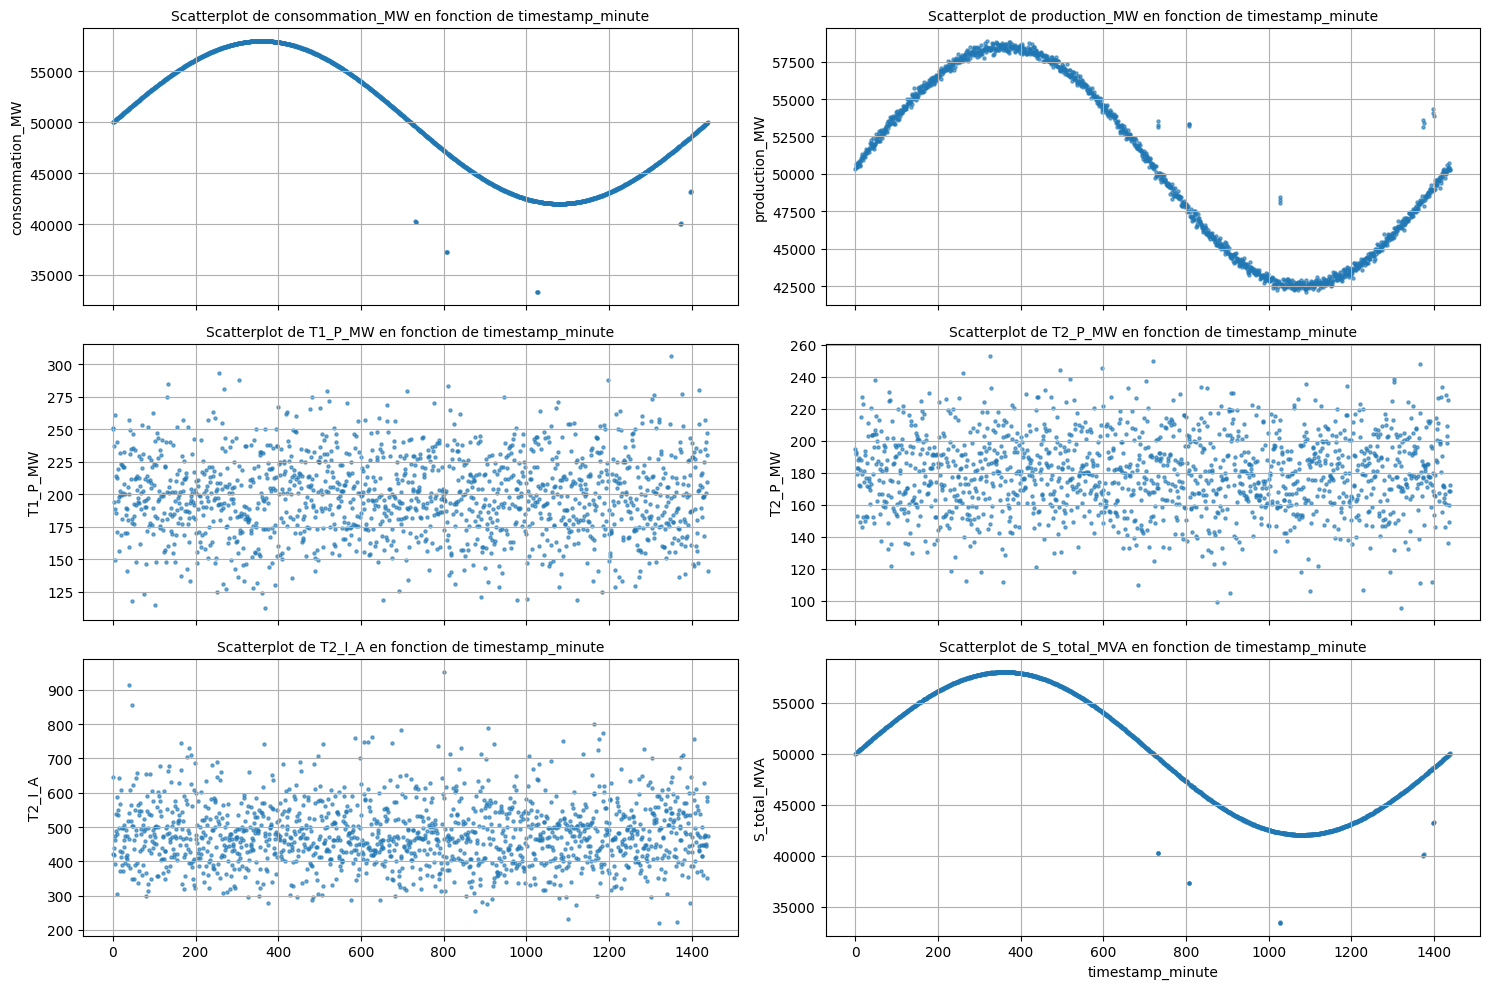

In [51]:
cols = [
    'consommation_MW',
    'production_MW',
    'T1_P_MW',
    'T2_P_MW',
    'T2_I_A',
    'S_total_MVA'
]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharex=True)
axs = axs.flatten()

for i, col in enumerate(cols):
    axs[i].scatter(df['timestamp_minute'], df[col], s=5, alpha=0.6)
    axs[i].set_title(f"Scatterplot de {col} en fonction de timestamp_minute", fontsize=10)
    axs[i].set_ylabel(col)
    axs[i].grid(True)

axs[-1].set_xlabel("timestamp_minute")
plt.tight_layout()
plt.show()

### Analyse

## consommation_MW en fonction de timestamp_minute
Comportement sinusoïdal régulier typique d’un cycle journalier de consommation.

Les pics et creux indiquent les périodes de forte et faible demande électrique (probablement matinée et nuit).

Stabilité globale du profil, sauf quelques valeurs manquantes/anormales autour des creux (à vérifier).

## production_MW en fonction de timestamp_minute
Profil également cyclique et synchronisé avec la consommation.

Légers décalages ou écarts entre production et consommation visibles à certains instants → à étudier (régulation ? import/export ?).

Données plutôt propres.

## T1_P_MW en fonction de timestamp_minute
Valeurs dispersées autour d’un centre (~230 MW), sans tendance temporelle nette.

Variabilité maîtrisée, pas d’évolution structurelle visible.

Comportement probablement constant dans le temps (composante stationnaire).

## T2_P_MW en fonction de timestamp_minute
Même observation que pour T1_P_MW.

Dispersion autour de ~180 MW.

Indique une production locale stable, probablement issue d’une sous-station ou d’une unité à puissance fixe.

## T2_I_A en fonction de timestamp_minute
Courant d’intensité avec forte variabilité, entre ~200 A et ~900 A.

Le nuage suggère une charge fluctuante, sans dérive notable ni rupture → comportement normal pour des charges dynamiques.

Aucun signe de surintensité persistante.

## S_total_MVA en fonction de timestamp_minute
Profil similaire à la consommation/production → cohérence physique, la puissance apparente suit la demande réelle.

Forme bien lissée → bon échantillonnage et mesure stable.

Pas de saturation visible du réseau (pas de pics extrêmes).



## Analyse bivariee des autres variables continues entre elles

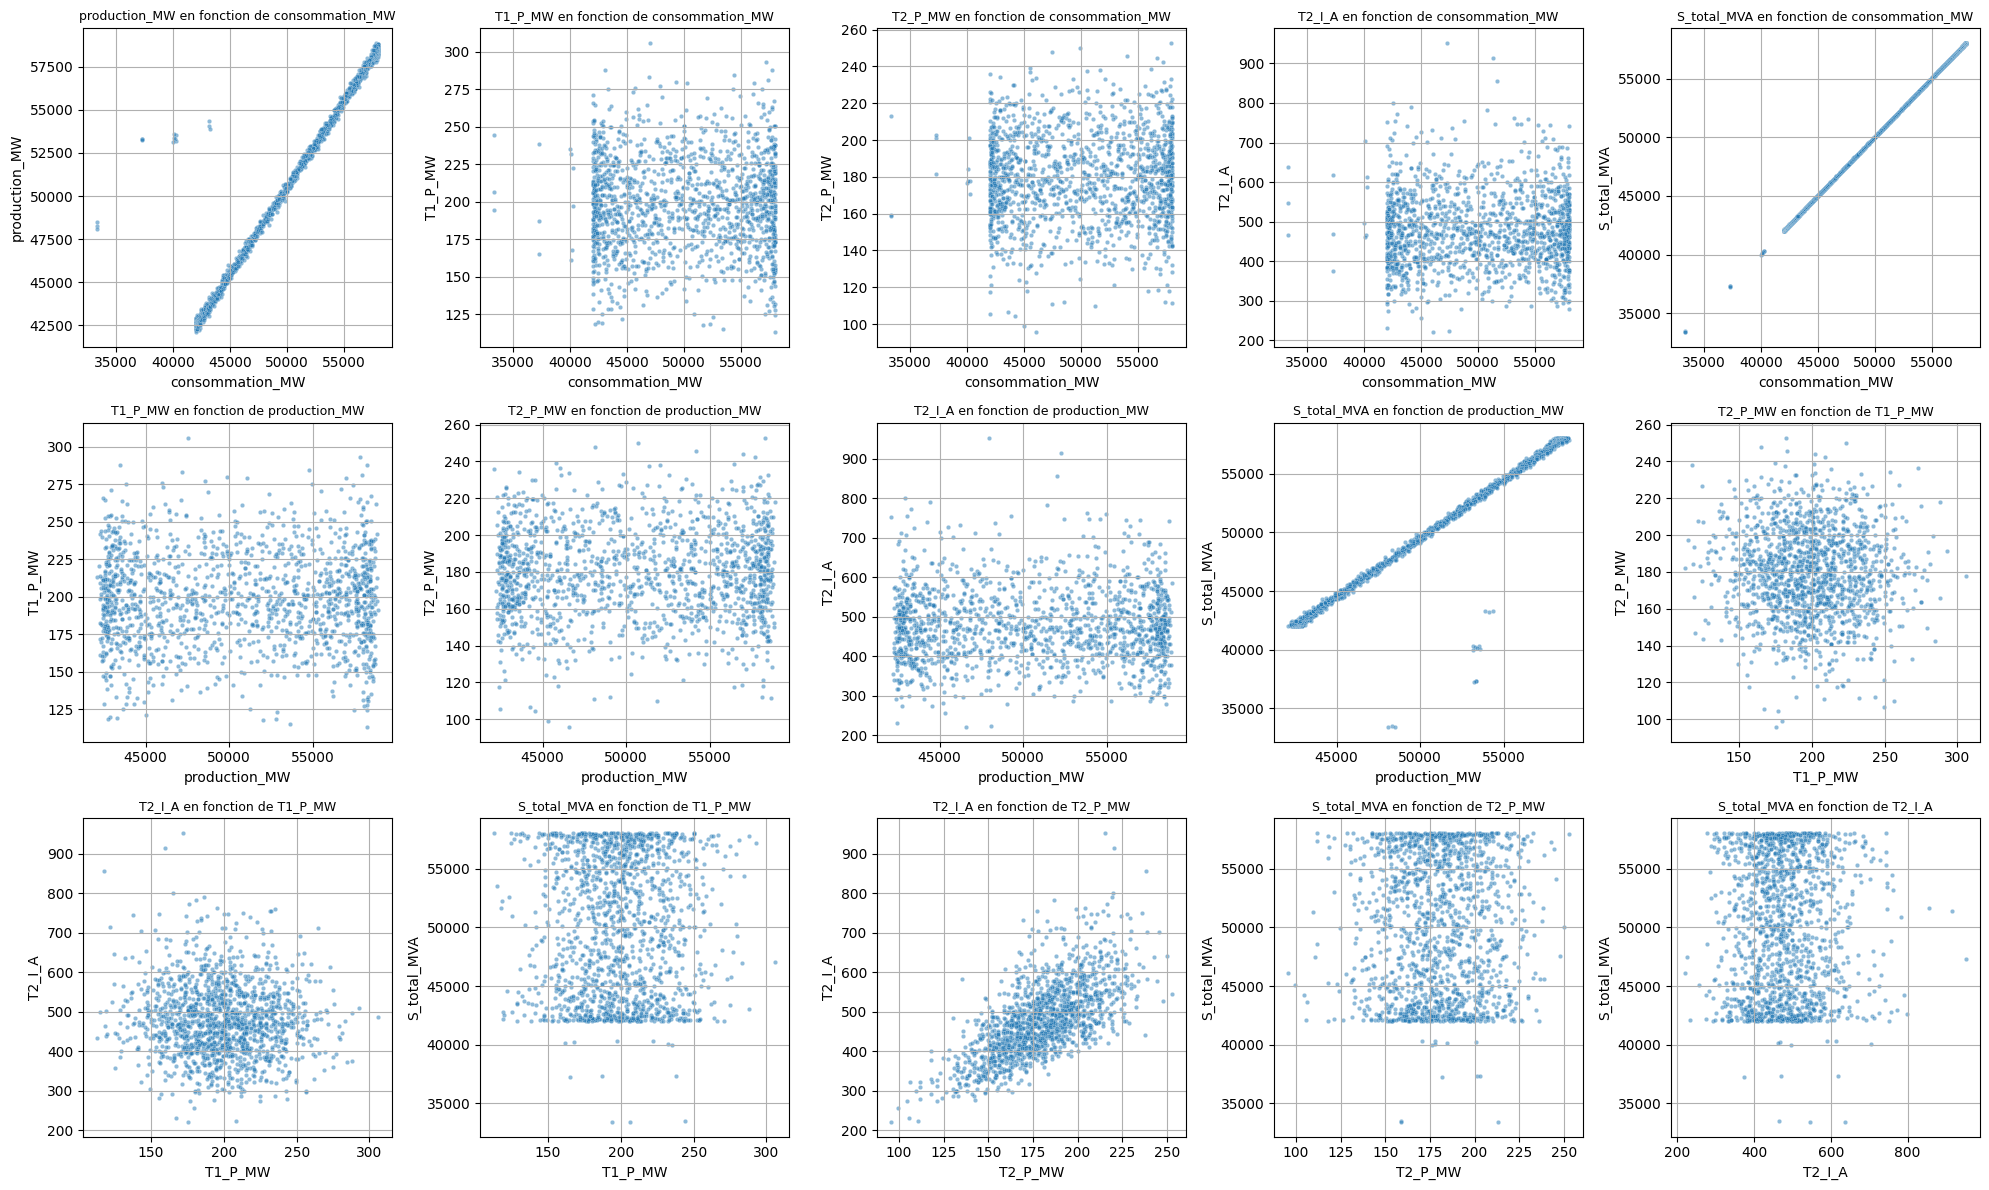

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Variables concernées
cols = [
    'consommation_MW',
    'production_MW',
    'T1_P_MW',
    'T2_P_MW',
    'T2_I_A',
    'S_total_MVA'
]

# Toutes les combinaisons 2 à 2
pairs = list(combinations(cols, 2))

# Paramètres de la grille
n_cols = 5
n_rows = (len(pairs) // n_cols) + (len(pairs) % n_cols > 0)

# Création des subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

# Générer les scatterplots
for i, (x, y) in enumerate(pairs):
    sns.scatterplot(data=df, x=x, y=y, ax=axs[i], s=10, alpha=0.5)
    axs[i].set_title(f"{y} en fonction de {x}", fontsize=9)
    axs[i].set_xlabel(x)
    axs[i].set_ylabel(y)
    axs[i].grid(True)

# Supprimer les axes vides restants
for j in range(len(pairs), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## Analyse

## 🔷 1. production_MW en fonction de consommation_MW
Analyse : Relation linéaire quasi parfaite.
Conclusion : La production suit très étroitement la consommation, ce qui reflète un équilibre instantané entre offre et demande du système électrique — cohérent avec la logique d’exploitation RTE.

## 🔷 2. T1_P_MW en fonction de consommation_MW
Analyse : Aucune corrélation visible.
Conclusion : La puissance active sur le transformateur T1 n’est pas directement influencée par la charge globale, ce qui suggère un dispatching local ou des contraintes techniques indépendantes.

## 🔷 3. T2_P_MW en fonction de consommation_MW
Analyse : Nuage dispersé, sans tendance.
Conclusion : La production du transformateur T2 est décorrélée de la consommation totale, ce qui reflète une autonomie locale ou régulation indépendante.

## 🔷 4. T2_I_A en fonction de consommation_MW
Analyse : Dispersion élevée, absence de structure.
Conclusion : Le courant sur T2 ne varie pas en fonction de la charge système, ce qui est cohérent avec une régulation par seuils ou priorisation de zones.

## 🔷 5. S_total_MVA en fonction de consommation_MW
Analyse : Relation quasi linéaire.
Conclusion : La puissance apparente suit logiquement la consommation active, indiquant un facteur de puissance relativement stable sur l'ensemble du réseau.

## 🔷 6. T1_P_MW en fonction de production_MW
Analyse : Aucune structure visible.
Conclusion : T1_P semble indépendant de la production totale, indiquant une répartition multi-sources de la génération.

## 🔷 7. T2_P_MW en fonction de production_MW
Analyse : Forte dispersion.
Conclusion : Même logique que pour T1 : pas de contribution systématique de T2 à la production totale.

## 🔷 8. T2_I_A en fonction de production_MW
Analyse : Pas de relation visible.
Conclusion : Le courant de T2 est déconnecté des variations de production globale, illustrant probablement une fonction spécifique ou un régime permanent.

## 🔷 9. S_total_MVA en fonction de production_MW
Analyse : Corrélation linéaire forte.
Conclusion : Confirme que la production conditionne fortement le niveau de charge apparente du réseau.

## 🔷 10. T2_P_MW en fonction de T1_P_MW
Analyse : Nuage homogène, sans corrélation.
Conclusion : T1 et T2 fonctionnent indépendamment, probablement affectés à des zones différentes.

## 🔷 11. T2_I_A en fonction de T1_P_MW
Analyse : Dispersion forte.
Conclusion : Les grandeurs des deux transformateurs ne sont pas synchronisées, indiquant une gestion décentralisée.

## 🔷 12. S_total_MVA en fonction de T1_P_MW
Analyse : Pas de corrélation forte.
Conclusion : Le rôle de T1 dans la charge globale semble limité ou très localisé.

## 🔷 13. T2_I_A en fonction de T2_P_MW
Analyse : Corrélation positive forte (quasi linéaire).
Conclusion : Comportement attendu physiquement : plus la puissance délivrée par T2 augmente, plus son courant augmente.

## 🔷 14. S_total_MVA en fonction de T2_P_MW
Analyse : Corrélation moyenne, tendance perturbée.
Conclusion : T2 contribue partiellement à la charge apparente, mais avec variabilité significative.

## 🔷 15. S_total_MVA en fonction de T2_I_A
Analyse : Forte dispersion.
Conclusion : Le courant T2 n’influence pas directement la charge apparente globale, soulignant une fonction locale de T2 ou des phénomènes de compensation.

## discrete / continue

### cos_phi  consommation_MW,  cos_phi/production_MW,   cos_phi/T1_P_MW,   cos_phi/T2_P_MW,    cos_phi/T2_Q_MVAR,    cos_phi/T2_I_A,       cos_phi/Q_total_MVAR,    cos_phi/S_total_MVA

In [53]:
df.groupby('cos_phi')['consommation_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,33338.000000,NaN,33338.0,33338.00,33338.0,33338.00,33338.0
0.997,2.0,37681.500000,6165.264025,33322.0,35501.75,37681.5,39861.25,42041.0
0.998,113.0,44407.876106,3116.042560,33330.0,42352.00,43779.0,45625.00,56842.0
0.999,1061.0,49675.646560,5629.879142,37231.0,44086.00,49546.0,55105.00,57999.0
1.000,263.0,53397.007605,4736.033408,40001.0,50601.50,55238.0,57249.00,57999.0


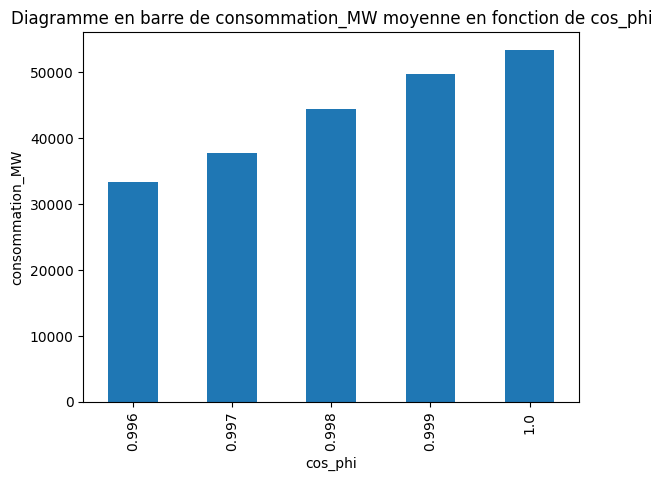

In [54]:
df.groupby('cos_phi', observed=True)['consommation_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de consommation_MW moyenne en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('consommation_MW')
plt.show()

### Analyse

Le diagramme en barres représente l’évolution de la consommation moyenne d’électricité (en MW) en fonction du facteur de puissance cos_phi. On observe une tendance croissante très marquée : plus le facteur de puissance est élevé, plus la consommation moyenne est importante. Ce phénomène est cohérent sur le plan physique, car un cos_phi plus proche de 1 indique un meilleur rendement énergétique : la puissance transmise est essentiellement active, donc réellement utilisée.

Lorsque cos_phi atteint la valeur maximale de 1.0, la consommation moyenne culmine à près de 54 000 MW, ce qui reflète probablement un fonctionnement optimal du réseau, avec peu ou pas de puissance réactive en circulation. À l’inverse, pour des valeurs plus faibles comme 0.996 ou 0.997, la consommation chute fortement, indiquant un déséquilibre ou une inefficacité énergétique, probablement causée par une mauvaise compensation de la puissance réactive.

Il convient néanmoins de relativiser cette conclusion car la distribution des effectifs est déséquilibrée : certaines modalités (comme cos_phi = 0.996 ou 0.997) sont très peu représentées, ce qui peut biaiser les moyennes associées. En revanche, les valeurs 0.998 et 0.999 sont largement représentées, ce qui renforce la fiabilité de la tendance observée dans cette zone.

En résumé, cette analyse confirme que le maintien d’un facteur de puissance élevé est bénéfique pour le réseau, à la fois en termes d’efficacité et de performance énergétique. Il est donc recommandé, en contexte opérationnel, de surveiller attentivement les périodes où le cos_phi chute, car elles peuvent être symptomatiques d’un mauvais pilotage du réseau ou d’un défaut de compensation.

In [55]:
df.groupby('cos_phi')['production_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,48291.000000,NaN,48291.0,48291.00,48291.0,48291.00,48291.0
0.997,2.0,45716.500000,3922.321315,42943.0,44329.75,45716.5,47103.25,48490.0
0.998,113.0,45375.884956,3182.455655,42222.0,42960.00,44360.0,46387.00,57677.0
0.999,1061.0,50286.414703,5572.119594,42113.0,44654.00,50235.0,55725.00,58882.0
1.000,263.0,53953.684411,4652.670105,42356.0,51220.00,55789.0,57773.00,58841.0


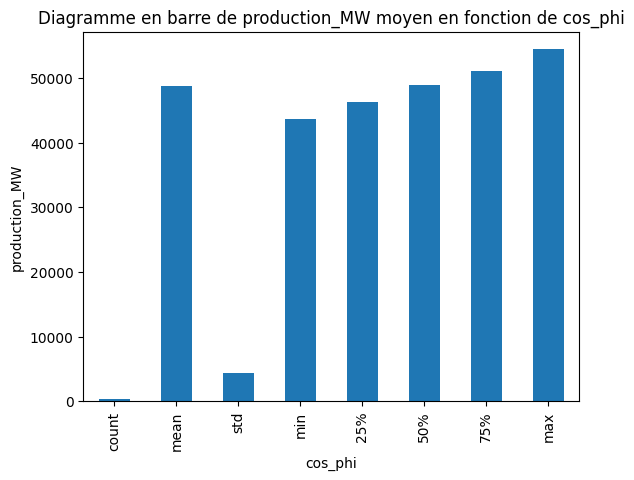

In [56]:
df.groupby('cos_phi')['production_MW'].describe().mean().plot(kind='bar')
plt.title('Diagramme en barre de production_MW moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('production_MW')
plt.show()

### Analyse

L'analyse du diagramme en barres de la production moyenne d’électricité (MW) en fonction du facteur de puissance cos_phi nous donnes quelques insights. À l’instar de la consommation, on observe une corrélation positive claire entre cos_phi et la production : plus le facteur de puissance est élevé, plus la production moyenne d’électricité est importante.

Les valeurs moyennes montrent une progression régulière de la production, allant de ~48 291 MW pour cos_phi = 0.996 à ~53 953 MW pour cos_phi = 1.000. Cela signifie que lorsque le réseau est en condition optimale (facteur de puissance unitaire), la production est maximale, ce qui suggère un système électrique bien dimensionné et bien compensé.

Sur le plan opérationnel, cela traduit probablement un effet direct de l’amélioration du facteur de puissance sur l’efficacité globale du système de production. Moins de pertes réactives signifient que davantage d’énergie produite est effectivement active, ce qui soulage les générateurs.

En revanche, comme pour la consommation, les échantillons associés aux valeurs faibles de cos_phi (0.996 et 0.997) sont très peu nombreux, ce qui invite à interpréter leurs moyennes avec prudence. Le faible effectif peut refléter des conditions rares, voire aberrantes, qu’il serait pertinent d’investiguer (par exemple : perturbation, surcharge locale ou incident réseau).

En résumé, un facteur de puissance élevé optimise non seulement la consommation, mais aussi la production. Il constitue un indicateur clé de performance énergétique, à surveiller et à maintenir via des actions de compensation (batteries de condensateurs, régulation, etc.).

In [57]:
df.groupby('cos_phi')['T1_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,244.250000,NaN,244.25,244.250,244.25,244.25,244.25
0.997,2.0,195.710000,15.330075,184.87,190.290,195.71,201.13,206.55
0.998,113.0,198.472655,29.331049,128.45,175.770,196.59,220.45,275.90
0.999,1061.0,198.947945,31.348974,113.01,177.640,198.25,221.09,292.95
1.000,263.0,198.301027,30.534519,121.46,175.835,200.61,215.53,305.87


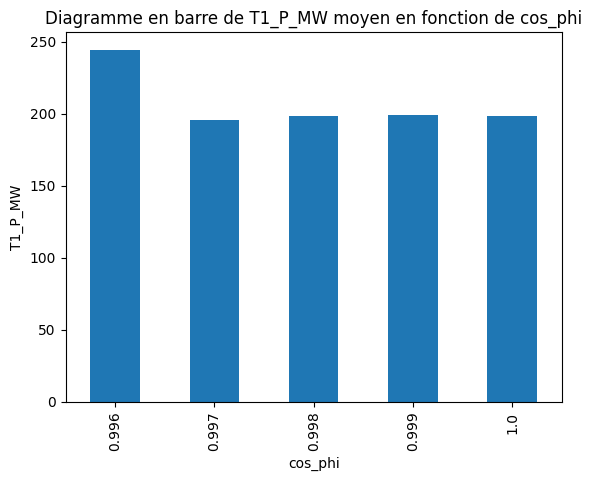

In [58]:
df.groupby('cos_phi')['T1_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T1_P_MW moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('T1_P_MW')
plt.show()

### Analyse

Le graphique en barres présente l’évolution de la puissance active de T1 (T1_P_MW) moyenne en fonction du facteur de puissance cos_phi.

Contrairement aux variables globales comme la consommation ou la production totales, la courbe ici est relativement stable autour de 198 MW, sans tendance marquée à la hausse ou à la baisse avec l’augmentation de cos_phi. Cette absence de corrélation claire peut s’expliquer par plusieurs hypothèses :

Comportement indépendant : Le transformateur T1 (ou poste mesuré) pourrait ne pas être sensible aux variations globales de facteur de puissance, en raison de régulations locales ou d’une stabilité de la charge connectée.

Compensation locale déjà optimisée : La puissance active de T1 est peut-être déjà maintenue de manière constante via des dispositifs de régulation, indépendamment des variations globales de cos_phi.

Cependant, on note une valeur élevée pour cos_phi = 0.996 (244.25 MW), ce qui détonne par rapport aux autres groupes. Cette anomalie est probablement due à un seul point de mesure (count = 1), ce qui rend la moyenne peu représentative. Il faut donc interpréter cette valeur avec prudence.

En conclusion, T1_P_MW ne varie pas significativement avec cos_phi, suggérant une indépendance opérationnelle vis-à-vis du facteur de puissance global, ou une régulation spécifique sur ce poste. Ce comportement mérite d’être confronté à celui de T2 ou à l’intensité pour confirmer ou infirmer cette stabilité apparente.

In [59]:
df.groupby('cos_phi')['T2_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,159.050000,NaN,159.05,159.0500,159.050,159.0500,159.05
0.997,2.0,196.005000,23.893138,179.11,187.5575,196.005,204.4525,212.90
0.998,113.0,177.855310,25.265642,95.61,159.9900,179.250,191.8300,232.93
0.999,1061.0,179.674317,24.457520,104.54,163.1000,178.960,196.5300,250.03
1.000,263.0,179.180646,23.253012,111.49,163.4000,179.480,195.1150,252.85


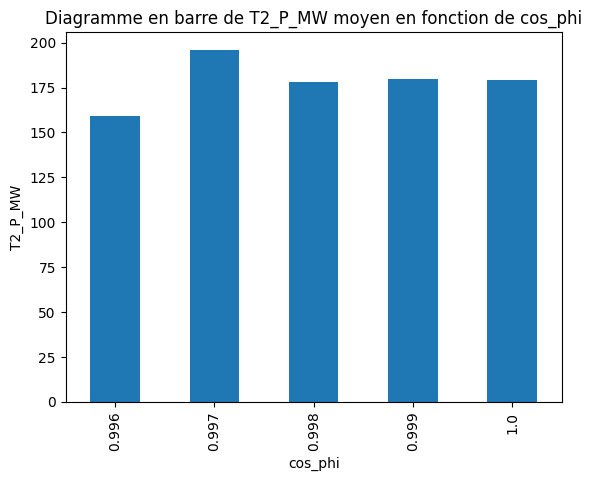

In [60]:
df.groupby('cos_phi')['T2_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_P_MW moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('T2_P_MW')
plt.show()

### Analyse:

Le diagramme en barres montre la variation de la puissance active de T2 (T2_P_MW) moyenne en fonction du facteur de puissance cos_phi.

Globalement, la courbe est relativement stable entre cos_phi = 0.998 et cos_phi = 1.000, avec une moyenne tournant autour de 179 MW, ce qui suggère que la puissance active de T2 est peu influencée par les variations du facteur de puissance global. Cela peut s’interpréter comme :

Une stabilité du poste T2, probablement liée à une charge constante ou à une régulation spécifique.

Une possible indépendance entre la consommation d’énergie active et la composante réactive du réseau à ce niveau.

Cependant, deux valeurs se démarquent :

cos_phi = 0.996 avec une moyenne de 159 MW, mais sur un seul point → cette valeur est non représentative statistiquement.

cos_phi = 0.997 avec une moyenne de 196 MW, basée sur seulement deux points, ce qui est également peu fiable.

Ces écarts mettent en évidence une variabilité artificielle due à la faible taille des échantillons pour certains groupes. Les groupes ayant un nombre de mesures suffisant (cos_phi ≥ 0.998) sont plus représentatifs.

Conclusion:
À partir de cos_phi ≥ 0.998, T2_P_MW reste relativement constant, ce qui suggère une indépendance vis-à-vis du facteur de puissance global. Les écarts aux faibles valeurs de cos_phi doivent être interprétés avec prudence à cause de la faible taille d’échantillon. Aucune tendance significative n’est observée, ce qui est cohérent avec un poste dont la puissance active est peu dépendante des fluctuations de la composante réactive du réseau.

In [61]:

df.groupby('cos_phi')['T2_Q_MVAR'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,33.030000,NaN,33.03,33.030,33.03,33.030,33.03
0.997,2.0,40.690000,0.919239,40.04,40.365,40.69,41.015,41.34
0.998,113.0,45.171593,9.177846,20.70,39.530,44.55,50.580,70.25
0.999,1061.0,45.021517,9.901900,14.66,38.370,44.95,51.300,78.78
1.000,263.0,45.054905,10.163942,11.79,39.190,44.88,51.715,77.84


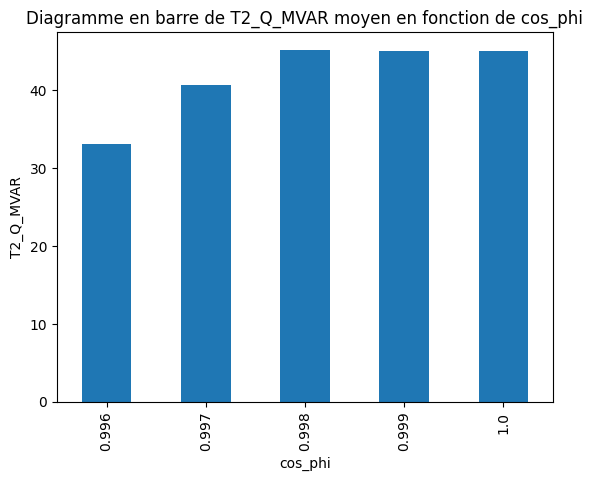

In [62]:
df.groupby('cos_phi')['T2_Q_MVAR'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_Q_MVAR moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('T2_Q_MVAR')
plt.show()

### Analyse
Le diagramme en barres présente la valeur moyenne de la puissance réactive de T2 (T2_Q_MVAR) en fonction du facteur de puissance (cos_phi).


On observe une augmentation progressive de la puissance réactive moyenne avec l'amélioration du facteur de puissance, allant d’environ 33 MVAR à cos_phi = 0.996 jusqu’à 45 MVAR à cos_phi = 1.000.

Cette tendance peut sembler contre-intuitive car un cos_phi plus élevé implique normalement une consommation moindre de puissance réactive. Cependant, ici il faut noter que :

Les valeurs faibles de cos_phi ont très peu d’observations (count = 1 pour 0.996, count = 2 pour 0.997), ce qui rend ces moyennes peu fiables.

Pour cos_phi ≥ 0.998, la moyenne reste stable autour de 45 MVAR avec très peu de variation, ce qui est plus représentatif et réaliste du comportement du réseau.

Interprétation:

Le poste T2 semble fonctionner de manière stable en réactif lorsque le facteur de puissance est proche de 1.

L’augmentation apparente n’est pas significative sur les valeurs élevées de cos_phi, ce qui suggère un régime stable et régulé du réseau.

Les faibles cos_phi ne permettent pas de tirer de conclusion robuste, en raison d’un échantillon insuffisant.

Conclusion :
La puissance réactive moyenne au niveau de T2 (T2_Q_MVAR) est globalement stable pour les valeurs de cos_phi ≥ 0.998, ce qui reflète un fonctionnement efficace du réseau avec peu de dispersion. Les valeurs observées pour cos_phi < 0.998 doivent être interprétées avec prudence.

In [63]:
df.groupby('cos_phi')['T2_I_A'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,465.500000,NaN,465.5,465.50,465.5,465.50,465.5
0.997,2.0,567.700000,98.994949,497.7,532.70,567.7,602.70,637.7
0.998,113.0,485.430973,117.843252,220.2,401.00,484.6,542.50,952.3
0.999,1061.0,479.102262,92.029307,224.4,416.60,470.9,532.30,914.8
1.000,263.0,474.914449,85.172670,287.6,418.65,466.0,530.75,746.0


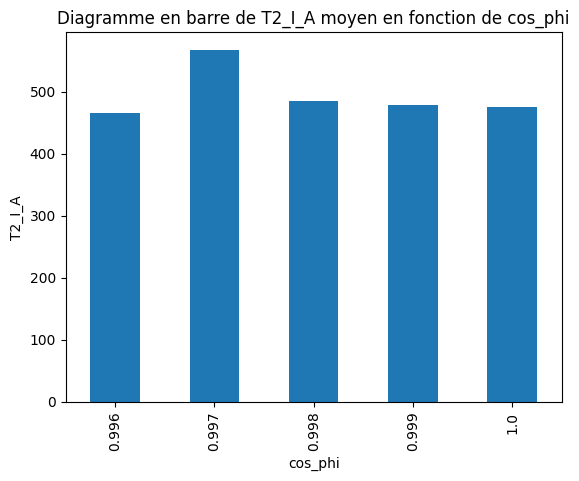

In [64]:
df.groupby('cos_phi')['T2_I_A'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_I_A moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('T2_I_A')
plt.show()

### Analyse

L'analyse du diagramme en barres et du tableau statistique montre la variation de l’intensité moyenne (T2_I_A) en fonction du facteur de puissance (cos_phi) sur le poste T2.

Analyse professionnelle :
Tendance générale : on observe une légère baisse de l’intensité moyenne lorsque cos_phi augmente. Cela est cohérent avec la théorie : un facteur de puissance élevé signifie un meilleur alignement entre la puissance active et la puissance apparente, donc moins de courant requis pour une même puissance délivrée.

Point notable : le pic observé à cos_phi = 0.997 (moyenne d’environ 567 A) est inhabituel. Il pourrait s’agir :

d’un effet de petit effectif (n=2 seulement),

ou d’un comportement transitoire ou événementiel à cette valeur de cos_phi.

Stabilité : pour les valeurs de cos_phi ≥ 0.998 (où les effectifs sont plus élevés), l’intensité est stable et décroît légèrement :

cos_phi = 0.998 → ~485 A

cos_phi = 0.999 → ~479 A

cos_phi = 1.000 → ~474 A

Variabilité (écart-type) : très élevé, surtout pour cos_phi = 0.998 et 0.999 (σ ≈ 117–92 A), ce qui reflète la variabilité du courant selon les conditions de charge du poste.

Conclusion :
La tendance observée est cohérente avec les lois électriques du transport d’énergie : un meilleur facteur de puissance réduit le courant nécessaire, ce qui diminue les pertes par effet Joule et améliore l’efficacité du réseau. Toutefois, les faibles effectifs pour cos_phi < 0.998 impliquent que seules les données à partir de cos_phi = 0.998 peuvent être jugées représentatives.



In [65]:
df.groupby('cos_phi')['Q_total_MVAR'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,2994.000000,NaN,2994.0,2994.00,2994.0,2994.00,2994.0
0.997,2.0,2903.500000,556.493037,2510.0,2706.75,2903.5,3100.25,3297.0
0.998,113.0,2607.230088,232.275276,2052.0,2432.00,2550.0,2768.00,3570.0
0.999,1061.0,2056.517436,295.845971,1344.0,1852.00,2058.0,2236.00,2964.0
1.000,263.0,1457.262357,229.962749,803.0,1282.00,1498.0,1639.50,1819.0


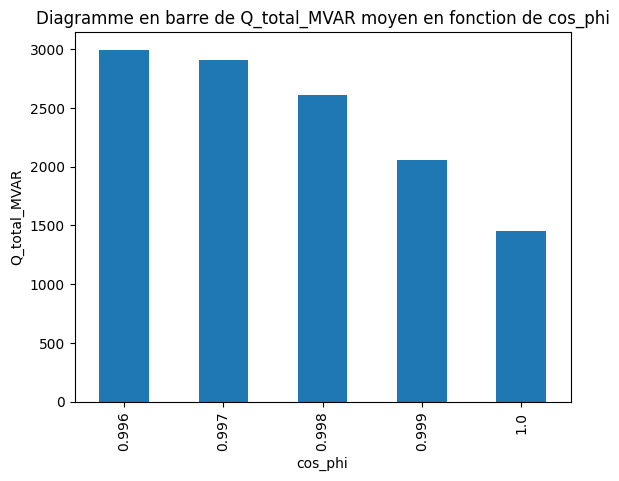

In [66]:
df.groupby('cos_phi')['Q_total_MVAR'].mean().plot(kind='bar')
plt.title('Diagramme en barre de Q_total_MVAR moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('Q_total_MVAR')
plt.show()

### Analyse

Ce diagramme en barres montre la variation moyenne de la puissance réactive totale (Q_total_MVAR) en fonction du facteur de puissance (cos_phi). L’analyse révèle une décroissance nette de la puissance réactive lorsque cos_phi augmente, ce qui est conforme aux principes de fonctionnement des réseaux électriques.

Analyse technique
Tendance observée : plus cos_phi tend vers 1, plus la puissance réactive moyenne diminue. La valeur moyenne passe d’environ 2994 MVAR pour cos_phi = 0.996 à 1457 MVAR pour cos_phi = 1.000.

Explication physique : un facteur de puissance élevé signifie que le réseau transporte principalement de la puissance active, avec peu de puissance réactive. Cela traduit un fonctionnement plus efficace du réseau, avec moins de pertes.

Conséquence opérationnelle : un bon pilotage du facteur de puissance permet de limiter la sollicitation des équipements (transformateurs, lignes), de réduire les pertes en ligne et d’améliorer la stabilité globale du réseau.


Les moyennes suivent une tendance monotone décroissante.

Les écarts-types restent raisonnables, ce qui indique une certaine stabilité statistique des mesures par catégorie de cos_phi.

Conclusion:

Le graphique confirme la relation inverse entre cos_phi et la puissance réactive. Cela souligne l’intérêt de maintenir un facteur de puissance élevé dans les réseaux haute tension, conformément aux bonnes pratiques d’exploitation chez RTE.


In [67]:
df.groupby('cos_phi')['S_total_MVA'].describe()

,count,mean,std,min,25%,50%,75%,max
cos_phi,,,,,,,,
0.996,1.0,33472.000000,NaN,33472.0,33472.0,33472.0,33472.0,33472.0
0.997,2.0,37793.000000,6190.012763,33416.0,35604.5,37793.0,39981.5,42170.0
0.998,113.0,44484.584071,3121.046556,33396.0,42417.0,43845.0,45704.0,56954.0
0.999,1061.0,49719.081998,5630.037770,37276.0,44131.0,49601.0,55153.0,58052.0
1.000,263.0,53417.254753,4737.458575,40010.0,50618.5,55254.0,57276.0,58028.0


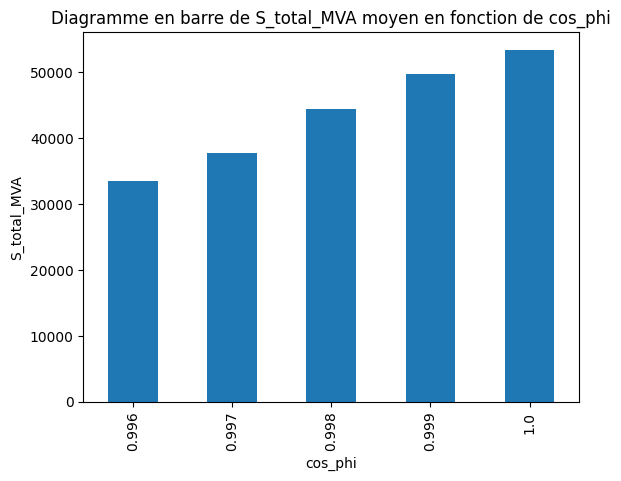

In [68]:
df.groupby('cos_phi')['S_total_MVA'].mean().plot(kind='bar')
plt.title('Diagramme en barre de S_total_MVA moyen en fonction de cos_phi')
plt.xlabel('cos_phi')
plt.ylabel('S_total_MVA')
plt.show()

### Analyse:

Le graphique montre une corrélation claire entre le facteur de puissance (cos_phi) et la puissance apparente moyenne (S_total_MVA). Plus cos_phi est élevé, plus la puissance apparente moyenne augmente. On passe d’environ 33 472 MVA à 0.996 à plus de 53 000 MVA à 1.000.

Cette tendance est cohérente : une amélioration du facteur de puissance (proche de 1) signifie une réduction des pertes liées à la puissance réactive, ce qui permet une meilleure efficacité du réseau et une montée en charge active.

D’un point de vue RTE, cela peut refléter soit :

une montée en charge du réseau,

soit une meilleure correction du facteur de puissance côté consommateurs.

Dans les deux cas, cela indique un réseau globalement mieux utilisé.

#### etat_reseau/consommation_MW,  etat_reseau/production_MW,   etat_reseau/T1_P_MW,   etat_reseau/T2_P_MW,    etat_reseau/T2_Q_MVAR,    etat_reseau/T2_I_A,etat_reseau/Q_total_MVAR,    etat_reseau/S_total_MVA

In [69]:
df.groupby('etat_reseau')['consommation_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,50030.819649,5672.210749,42000.0,44340.00,50122.0,55696.00,57999.0
1,8.0,38438.375000,3529.469929,33322.0,36257.75,40017.5,40202.75,43158.0
2,7.0,39234.285714,3555.564733,33330.0,37280.00,40068.0,41728.00,43226.0


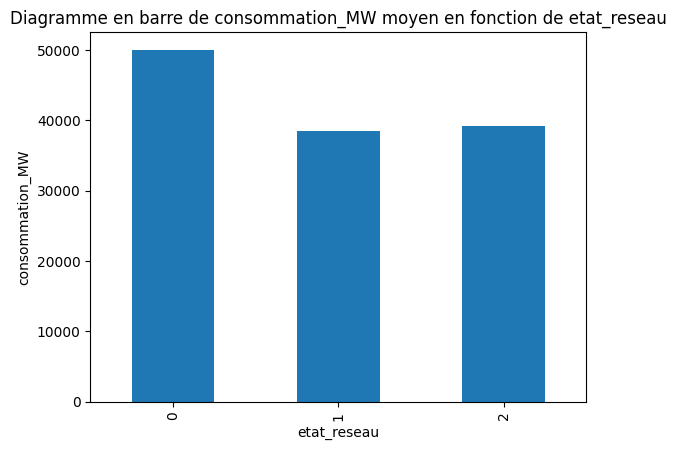

In [70]:
df.groupby('etat_reseau')['consommation_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de consommation_MW moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')
plt.ylabel('consommation_MW')
plt.show()

In [71]:
df.groupby('etat_reseau')['production_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,50543.007719,5671.672321,42113.0,44865.00,50619.0,56180.00,58882.0
1,8.0,52160.875000,2348.262180,48291.0,51976.75,53198.5,53366.25,54089.0
2,7.0,52833.000000,2136.577013,48064.0,53313.50,53377.0,53709.50,54344.0


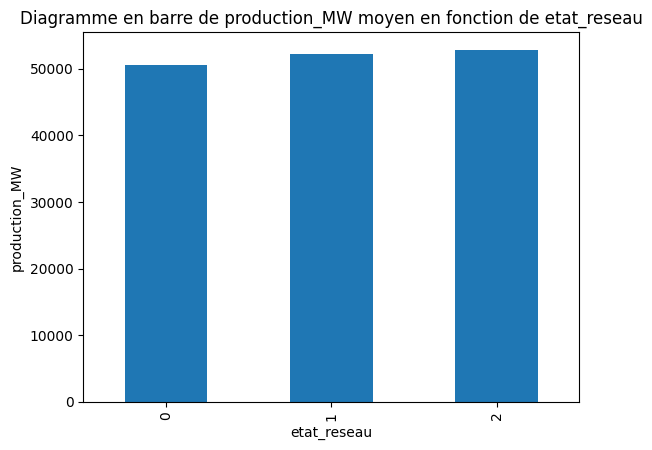

In [72]:
df.groupby('etat_reseau')['production_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de production_MW moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')
plt.ylabel('production_MW')
plt.show()

In [73]:
df.groupby('etat_reseau')['T1_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,198.817684,31.048273,113.01,177.380,198.640,220.450,305.87
1,8.0,204.207500,30.676910,164.92,181.535,201.895,232.770,244.25
2,7.0,193.022857,28.843779,160.97,174.225,187.110,208.225,238.18


Text(0.5, 0, 'etat_reseau')

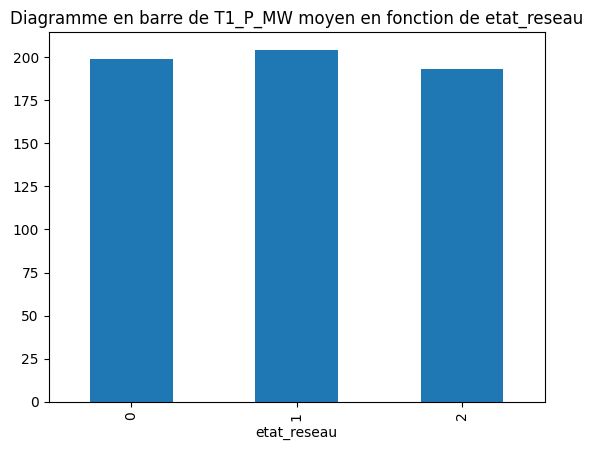

In [74]:
df.groupby('etat_reseau')['T1_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T1_P_MW moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')

In [75]:
df.groupby('etat_reseau')['T2_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,179.439165,24.356210,95.61,163.000,179.18,196.11,252.85
1,8.0,183.326250,16.449630,159.05,177.330,179.05,186.45,212.90
2,7.0,177.178571,19.630415,153.42,163.695,170.73,192.92,202.87


Text(0.5, 0, 'etat_reseau')

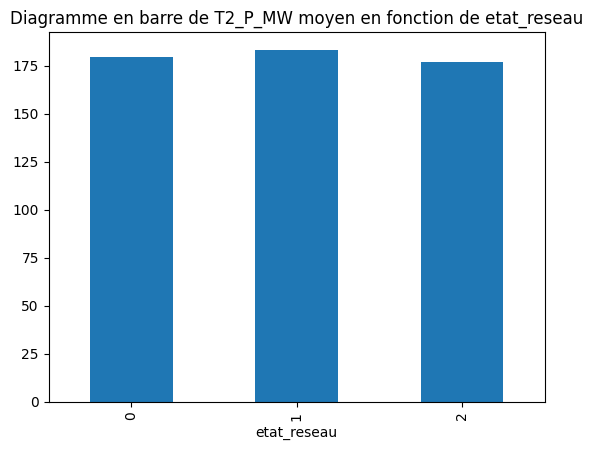

In [76]:
df.groupby('etat_reseau')['T2_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_P_MW moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')

In [77]:
df.groupby('etat_reseau')['T2_Q_MVAR'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,45.073207,9.873610,11.79,38.5900,44.950,51.4600,78.78
1,8.0,40.568750,6.081967,29.15,39.2625,43.475,43.8725,46.11
2,7.0,40.314286,14.236393,20.70,32.2000,39.760,46.0800,65.18


Text(0.5, 0, 'etat_reseau')

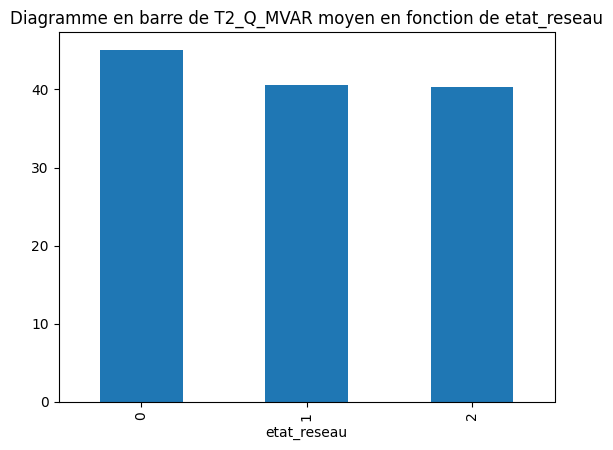

In [78]:
df.groupby('etat_reseau')['T2_Q_MVAR'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_Q_MVAR moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')

## Analyse:

La puissance réactive moyenne diminue légèrement de l’état 0 (≈45 MVAR) à l’état 2 (≈40 MVAR).
Mais les effectifs des états 1 et 2 sont trop faibles pour conclure (8 et 7 points).

Conclusion : seule l’info sur l’état 0 est fiable. Pas de tendance exploitable sans plus de données.

In [79]:
df.groupby('etat_reseau')['T2_I_A'].describe()

,count,mean,std,min,25%,50%,75%,max
etat_reseau,,,,,,,,
0,1425.0,478.368561,92.888147,220.2,415.80,470.60,532.40,952.3
1,8.0,533.462500,105.966382,374.3,466.55,515.55,600.95,703.5
2,7.0,534.528571,97.718485,386.1,465.90,546.50,615.10,647.1


Text(0.5, 0, 'etat_reseau')

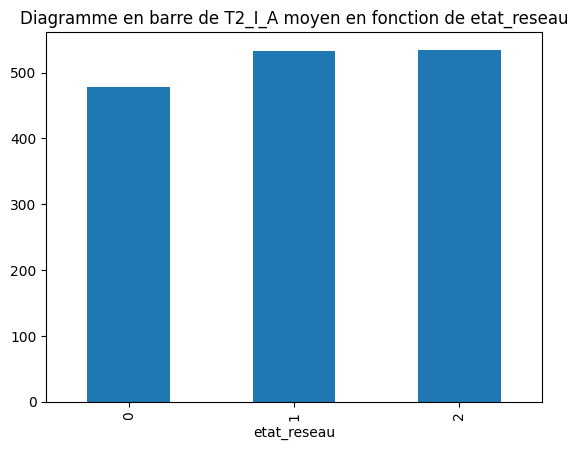

In [80]:
df.groupby('etat_reseau')['T2_I_A'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_I_A moyen en fonction de etat_reseau')
plt.xlabel('etat_reseau')

## Analyse globale etat_reseau avec les variables continues:

Toutes les métriques étudiées — telles que consommation_MW, production_MW, T1_P_MW, T2_P_MW, T2_Q_MVAR, T2_I_A, Q_total_MVAR, S_total_MVA — présentent des valeurs moyennes très similaires entre les différents états du réseau (etat_reseau ∈ {0, 1, 2}).

### zone_reseau /consommation_MW,  zone_reseau/production_MW,   zone_reseau/T1_P_MW,   zone_reseau/T2_P_MW,    zone_reseau/T2_Q_MVAR,    zone_reseau/T2_I_A,zone_reseau/Q_total_MVAR,    zone_reseau/S_total_MVA

In [81]:
df.groupby('zone_reseau')['consommation_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,50154.659794,5921.450494,37231.0,44063.00,50558.0,56080.50,57999.0
Est,306.0,50035.781046,5629.342108,42000.0,44060.50,50051.5,55653.25,57999.0
Nord,252.0,49990.591270,5612.426749,40194.0,44665.75,49729.0,55335.00,57997.0
Ouest,301.0,49580.478405,5772.854136,37264.0,43846.00,49371.0,55356.00,57999.0
Sud,290.0,49823.300000,5898.095460,33322.0,44142.75,50121.5,55534.50,57999.0


Text(0.5, 0, 'zone_reseau')

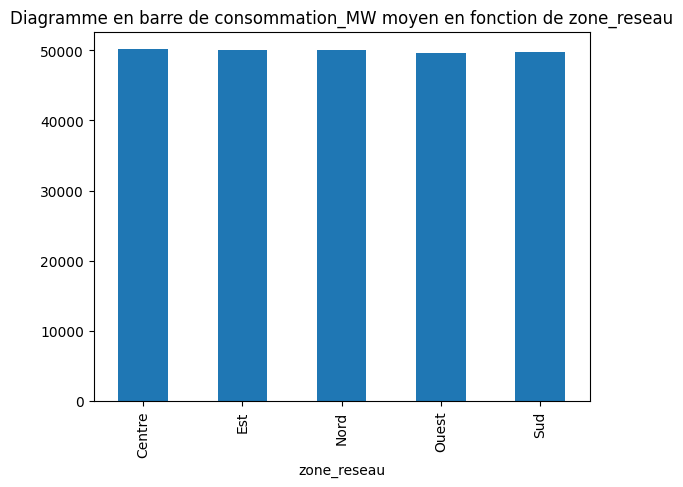

In [82]:
df.groupby('zone_reseau')['consommation_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de consommation_MW moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [83]:
df.groupby('zone_reseau')['production_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,50849.828179,5788.372798,42222.0,45107.00,51521.0,56598.50,58825.0
Est,306.0,50549.722222,5633.442557,42113.0,44599.00,50540.0,56062.50,58679.0
Nord,252.0,50604.761905,5548.926400,42452.0,45267.75,50298.0,56048.75,58823.0
Ouest,301.0,50220.049834,5665.823299,42258.0,44522.00,50400.0,55784.00,58730.0
Sud,290.0,50609.496552,5615.976355,42257.0,45054.25,50912.5,56014.75,58882.0


Text(0.5, 0, 'zone_reseau')

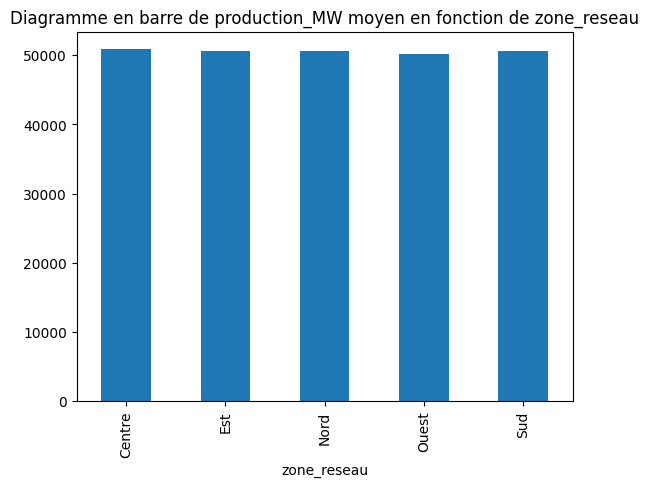

In [84]:
df.groupby('zone_reseau')['production_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de production_MW moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [85]:
df.groupby('zone_reseau')['T1_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,198.510653,31.854188,113.01,176.1000,200.880,220.9150,280.01
Est,306.0,197.713431,30.436909,115.01,177.2300,198.645,215.6525,292.95
Nord,252.0,203.358452,30.835263,126.94,184.6850,202.800,224.6550,305.87
Ouest,301.0,199.306512,30.784571,124.33,175.8300,197.950,220.5300,288.06
Sud,290.0,195.846621,30.946603,121.46,176.9475,194.585,215.1100,284.73


Text(0.5, 0, 'zone_reseau')

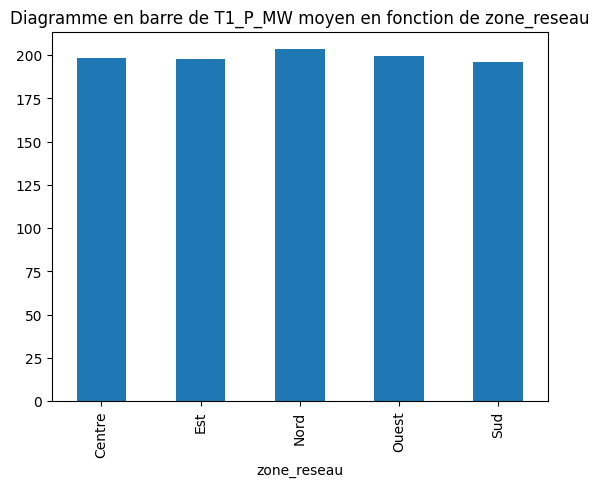

In [86]:
df.groupby('zone_reseau')['T1_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T1_P_MW moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [87]:
df.groupby('zone_reseau')['T2_P_MW'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,177.677801,24.414023,109.73,161.8300,177.97,193.7000,245.81
Est,306.0,179.292157,22.688508,104.54,163.2750,177.17,195.8225,244.32
Nord,252.0,179.842302,23.925400,117.72,163.1300,179.24,196.2825,247.87
Ouest,301.0,181.151395,26.286806,95.61,163.8800,181.58,199.8300,252.85
Sud,290.0,179.286897,23.998339,99.19,162.0275,179.98,195.9175,234.28


Text(0.5, 0, 'zone_reseau')

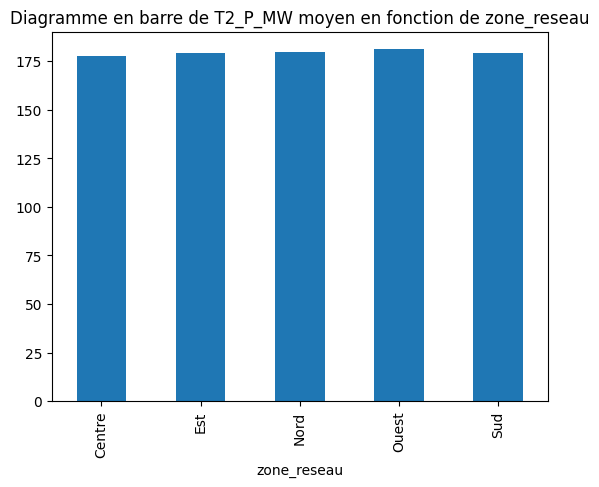

In [88]:
df.groupby('zone_reseau')['T2_P_MW'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_P_MW moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [89]:
df.groupby('zone_reseau')['T2_Q_MVAR'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,45.528969,9.444694,14.66,39.9350,45.130,51.7350,78.78
Est,306.0,44.944510,9.542423,17.92,38.6200,44.925,51.0625,77.88
Nord,252.0,44.047183,10.364235,15.91,36.9650,43.905,50.2725,70.80
Ouest,301.0,45.764585,9.883533,17.00,39.0900,45.570,51.9100,74.70
Sud,290.0,44.686517,10.221191,11.79,38.2025,44.290,51.5875,77.84


Text(0.5, 0, 'zone_reseau')

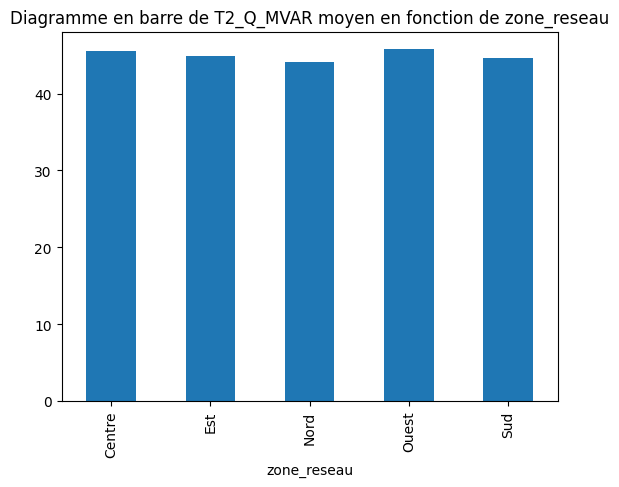

In [90]:
df.groupby('zone_reseau')['T2_Q_MVAR'].mean().plot(kind='bar')
plt.title('Diagramme en barre de T2_Q_MVAR moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [91]:
df.groupby('zone_reseau')['Q_total_MVAR'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,1994.512027,386.351139,828.0,1714.00,2017.0,2261.50,2912.0
Est,306.0,1957.578431,400.669541,803.0,1662.50,1949.0,2211.00,2928.0
Nord,252.0,1989.083333,419.242407,987.0,1694.50,1979.0,2232.50,3570.0
Ouest,301.0,2005.073090,403.678339,864.0,1758.00,2024.0,2272.00,3260.0
Sud,290.0,2015.327586,425.039456,918.0,1716.25,2013.5,2295.75,3125.0


Text(0.5, 0, 'zone_reseau')

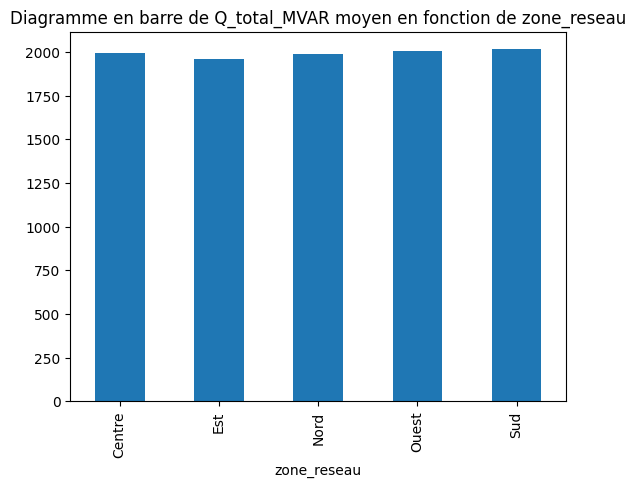

In [92]:
df.groupby('zone_reseau')['Q_total_MVAR'].mean().plot(kind='bar')
plt.title('Diagramme en barre de Q_total_MVAR moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

In [93]:
df.groupby('zone_reseau')['S_total_MVA'].describe()

,count,mean,std,min,25%,50%,75%,max
zone_reseau,,,,,,,,
Centre,291.0,50196.463918,5916.168538,37276.0,44116.0,50603.0,56118.00,58036.0
Est,306.0,50076.179739,5624.785022,42021.0,44104.5,50090.0,55688.50,58042.0
Nord,252.0,50032.321429,5608.652898,40242.0,44731.0,49775.5,55392.00,58049.0
Ouest,301.0,49623.295681,5767.189052,37320.0,43908.0,49440.0,55390.00,58051.0
Sud,290.0,49866.417241,5893.308860,33396.0,44196.0,50156.0,55558.75,58052.0


Text(0.5, 0, 'zone_reseau')

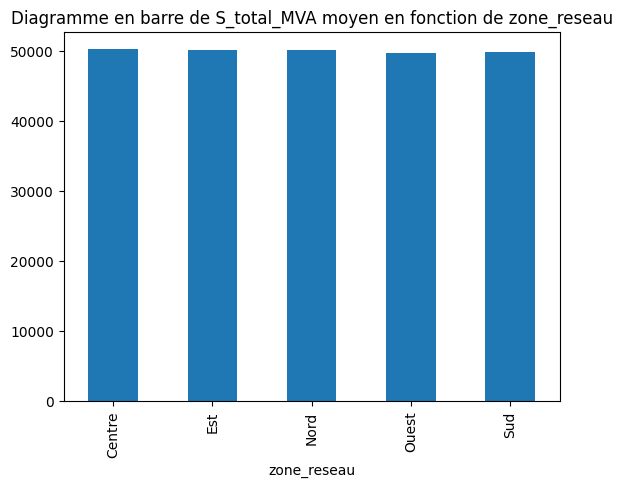

In [94]:
df.groupby('zone_reseau')['S_total_MVA'].mean().plot(kind='bar')
plt.title('Diagramme en barre de S_total_MVA moyen en fonction de zone_reseau')
plt.xlabel('zone_reseau')

### Analyse global entre zone reseau et les autres variables continues:

Les différentes courbes de moyennes par zone_reseau — incluant la consommation (consommation_MW), la production (production_MW), les puissances actives (T1_P_MW, T2_P_MW), la puissance réactive (T2_Q_MVAR, Q_total_MVAR), le courant (T2_I_A) et la puissance apparente (S_total_MVA) — présentent une stabilité remarquable entre les zones : Centre, Est, Nord, Ouest, Sud.

Les écarts sont faibles, traduisant un équilibrage homogène du réseau électrique en termes de charge et de transit électrique. Cela suggère que la répartition géographique des usages, des productions, et des infrastructures est bien dimensionnée à l’échelle nationale ou régionale

## Pour voir Évaluer si les variables électriques varient significativement selon 3 facteurs structurels du réseau on fait un test de KRUSKAL WALIS ( car les classes sont desequilibrees)

In [95]:
from scipy.stats import kruskal

def run_kruskal_test(df, group_col, variables, alpha=0.05):
    results = []
    for var in variables:
        groups = [group[var].dropna() for _, group in df.groupby(group_col)]
        if all(len(g) > 0 for g in groups):
            stat, p_value = kruskal(*groups)
            hypothesis = f"H0: Il n'y a pas de différence significative de '{var}' selon '{group_col}'"
            interpretation = "Nous avons suffisamment d'évidences pour rejeter H0" if p_value < alpha else "Nous n'avons pas suffisamment d'évidences pour rejeter H0"
            results.append({
                "variable": var,
                "group_by": group_col,
                "statistic": stat,
                "p_value": p_value,
                "interpretation": interpretation
            })
    return pd.DataFrame(results)

# Exemple d'utilisation :
variables = [
    'T1_P_MW', 'T2_P_MW', 'T2_Q_MVAR',
    'T2_I_A', 'Q_total_MVAR', 'S_total_MVA',
    'consommation_MW', 'production_MW'
]

kruskal_results_etat = run_kruskal_test(df, 'etat_reseau', variables)
display(kruskal_results_etat)

kruskal_results_zone = run_kruskal_test(df, 'zone_reseau', variables)
display(kruskal_results_zone)

kruskal_results_cosphi = run_kruskal_test(df, 'cos_phi', variables)
display(kruskal_results_cosphi)


,variable,group_by,statistic,p_value,interpretation
0,T1_P_MW,etat_reseau,0.579312,7.485211e-01,Nous n'avons pas suffisamment d'évidences pour...
1,T2_P_MW,etat_reseau,0.327105,8.491219e-01,Nous n'avons pas suffisamment d'évidences pour...
2,T2_Q_MVAR,etat_reseau,3.557016,1.688899e-01,Nous n'avons pas suffisamment d'évidences pour...
3,T2_I_A,etat_reseau,4.633207,9.860792e-02,Nous n'avons pas suffisamment d'évidences pour...
4,Q_total_MVAR,etat_reseau,0.164335,9.211175e-01,Nous n'avons pas suffisamment d'évidences pour...
5,S_total_MVA,etat_reseau,38.497548,4.368816e-09,Nous avons suffisamment d'évidences pour rejet...
6,consommation_MW,etat_reseau,38.506018,4.350353e-09,Nous avons suffisamment d'évidences pour rejet...
7,production_MW,etat_reseau,1.105171,5.754600e-01,Nous n'avons pas suffisamment d'évidences pour...


,variable,group_by,statistic,p_value,interpretation
0,T1_P_MW,zone_reseau,8.983709,0.061508,Nous n'avons pas suffisamment d'évidences pour...
1,T2_P_MW,zone_reseau,3.002367,0.557429,Nous n'avons pas suffisamment d'évidences pour...
2,T2_Q_MVAR,zone_reseau,5.917984,0.205358,Nous n'avons pas suffisamment d'évidences pour...
3,T2_I_A,zone_reseau,3.186698,0.527082,Nous n'avons pas suffisamment d'évidences pour...
4,Q_total_MVAR,zone_reseau,4.234229,0.375233,Nous n'avons pas suffisamment d'évidences pour...
5,S_total_MVA,zone_reseau,1.346869,0.853375,Nous n'avons pas suffisamment d'évidences pour...
6,consommation_MW,zone_reseau,1.343638,0.853929,Nous n'avons pas suffisamment d'évidences pour...
7,production_MW,zone_reseau,1.807048,0.771193,Nous n'avons pas suffisamment d'évidences pour...


,variable,group_by,statistic,p_value,interpretation
0,T1_P_MW,cos_phi,2.379590,6.663189e-01,Nous n'avons pas suffisamment d'évidences pour...
1,T2_P_MW,cos_phi,2.520585,6.409535e-01,Nous n'avons pas suffisamment d'évidences pour...
2,T2_Q_MVAR,cos_phi,2.737471,6.026738e-01,Nous n'avons pas suffisamment d'évidences pour...
3,T2_I_A,cos_phi,2.818921,5.885710e-01,Nous n'avons pas suffisamment d'évidences pour...
4,Q_total_MVAR,cos_phi,702.055614,1.250655e-150,Nous avons suffisamment d'évidences pour rejet...
5,S_total_MVA,cos_phi,196.851936,1.785028e-41,Nous avons suffisamment d'évidences pour rejet...
6,consommation_MW,cos_phi,201.394245,1.884100e-42,Nous avons suffisamment d'évidences pour rejet...
7,production_MW,cos_phi,187.434016,1.886464e-39,Nous avons suffisamment d'évidences pour rejet...
